In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import efficientnet_v2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB4, EfficientNetB2
from tensorflow.keras.applications import VGG16, VGG19, MobileNet, EfficientNetB3, EfficientNetB2

import collections
from collections import Counter
import pandas as pd
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, auc, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from imblearn.under_sampling import RandomUnderSampler
import random
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

import seaborn as sns
from tensorflow.keras.optimizers import Adam
import json

import torch
import os

import json
import tensorflow as tf
from tensorflow.keras.callbacks import Callback

In [2]:
import tensorflow as tf

# Cek apakah ada GPU yang terdeteksi
gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("GPU detected:")
    for gpu in gpus:
        print(f"- {gpu}")
else:
    print("No GPU detected.")


GPU detected:
- PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [4]:
#set the dataset path
data_dir = "archive/Tea_Leaf_Disease"

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, False)
    except RuntimeError as e:
        print(e)

In [6]:
# Memilih GPU pertama untuk digunakan
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Membatasi penggunaan GPU pertama
        tf.config.set_visible_devices(gpus[0], 'GPU')
        print("Using GPU:", gpus[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


**BATCH SIZE DAN SPLIT MANUAL**

In [7]:
# Set global seed for reproducibility
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.manual_seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.use_deterministic_algorithms(True)

os.environ['PYTHONHASHSEED'] = str(seed)
tf.keras.utils.set_random_seed(seed)

tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

tf.keras.mixed_precision.set_global_policy('float32')

In [8]:
def convert_tensor_to_serializable(tensor):
    if isinstance(tensor, tf.Tensor):
        return tensor.numpy()
    return tensor

# Custom callback untuk menyimpan logs dalam format JSON
class CustomJSONLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Convert logs to JSON-serializable format
        logs = {key: convert_tensor_to_serializable(value) for key, value in logs.items()}
        
        # Log to a file or perform some custom action
        with open('training_logs.json', 'a') as f:
            json.dump(logs, f)
            f.write('\n')


In [9]:
def load_dataset(data_dir, image_size, batch_size, seed):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        image_size=image_size,
        batch_size=batch_size,
        seed=seed
    )
    return dataset

def stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed):
    # Unbatch the dataset to work with raw images and labels
    unbatched_ds = list(dataset.unbatch())
    images, labels = zip(*[(img.numpy(), label.numpy()) for img, label in unbatched_ds])
    images = np.array(images)
    labels = np.array(labels)

    if sample_size is None:
        images_resampled = images
        labels_resampled = labels
    else:
        # Melakukan under-sampling untuk setiap label sesuai dengan sample_size
        rus = RandomUnderSampler(
            sampling_strategy={i: sample_size for i in np.unique(labels)}, 
            random_state=seed
        )
        images_resampled, labels_resampled = rus.fit_resample(images.reshape((images.shape[0], -1)), labels)
        images_resampled = images_resampled.reshape((-1, *image_size, 3))

    # Split dataset into train and validation sets (80% train, 20% validation)
    train_images, val_images, train_labels, val_labels = train_test_split(
        images_resampled,
        labels_resampled,
        test_size=split_ratio,
        random_state=seed,
        stratify=labels_resampled
    )

    # Convert back to TensorFlow dataset format
    train_ds = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(batch_size)
    val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(batch_size)

    return train_ds, val_ds

def data_augmentation(train_ds, augmentation_factor, batch_size):
    # Membuat layer augmentasi
    random_flip = RandomFlip("horizontal_and_vertical", seed=seed)
    random_rotation = RandomRotation(factor=(90 / 360), seed=seed)
    random_zoom = RandomZoom(0.2, seed=seed)
    random_contrast = RandomContrast(0.2, seed=seed)
    # Fungsi augmentasi
    @tf.function
    def augment_image(image, label):
        image = random_flip(image)
        image = random_rotation(image)
        image = random_zoom(image)
        image = random_contrast(image)
        return image, label

    num_augmented_samples = int(len(list(train_ds.unbatch())) * augmentation_factor)
    augmented_ds = train_ds.unbatch().take(num_augmented_samples).map(augment_image).batch(batch_size)
    train_ds_aug = train_ds.concatenate(augmented_ds)
    
    return train_ds_aug

from tensorflow.keras.applications import ResNet50, InceptionV3, DenseNet201,  EfficientNetB6, EfficientNetB5, EfficientNetB3
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

def build_model(model_name, image_size, num_classes=6):
    if model_name == 'VGG16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'VGG19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'MobileNet':
        base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'ResNet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'InceptionV3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'DenseNet201':
        base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    
    elif model_name == 'EfficientNetV2B0':
        base_model = efficientnet_v2.EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2B1':
        base_model = efficientnet_v2.EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2B1':
        base_model = efficientnet_v2.EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2B2':
        base_model = efficientnet_v2.EfficientNetV2B2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2B3':
        base_model = efficientnet_v2.EfficientNetV2B3(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2S':
        base_model = efficientnet_v2.EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
        
    elif model_name == 'EfficientNetV2M':
        base_model = efficientnet_v2.EfficientNetV2M(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetV2L':
        base_model = efficientnet_v2.EfficientNetV2L(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetB2':
        base_model = EfficientNetB2(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
        
    elif model_name == 'EfficientNetB4':
        base_model = EfficientNetB4(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    elif model_name == 'EfficientNetB5':
        base_model = EfficientNetB5(weights='imagenet', include_top=False, input_shape=(*image_size, 3))
    
    else:
        raise ValueError(f"Model {model_name} tidak didukung.")

    base_model.trainable = False  # Fine-tuning dapat dilakukan setelah pelatihan awal

    # Model hanya menggunakan base_model tanpa lapisan tambahan
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(num_classes, activation='softmax')
    ])

    # Summary of the model
    model.summary()

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.001),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

def train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6):
    checkpoint = ModelCheckpoint(
        f'best_model_{name}.keras',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    )
    
    # Fit the model with checkpoint
    history = model.fit(
        train_ds_aug,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[checkpoint],
        verbose=1
    )
    
    # Simpan model terakhir (full model)
    model.save(f'full_model_{name}.keras')

    # Simpan history pelatihan dalam format JSON
    with open(f'history_{name}.json', 'w') as f:
        json.dump(history.history, f)

    # Load best model based on validation
    best_model = keras.models.load_model(f'best_model_{name}.keras')

    # Get evaluation results for loaded model
    val_loss, val_accuracy = best_model.evaluate(val_ds)

    # Get epoch from saved model
    best_val_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_train_accuracy = max(history.history['accuracy'])

    # Print accuracy results and model information
    print(f"Model saved at Epoch: {best_val_epoch}")
    print(f"Validation Accuracy: {val_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")
    print(f"Training Accuracy: {best_train_accuracy:.4f}")

    # 1. Generate predictions for validation data
    y_pred_prob = best_model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Assuming `val_ds` has labels, extract true labels
    y_true = np.concatenate([y for x, y in val_ds], axis=0)

    # Get class names from the dataset
    class_names = dataset.class_names

    # 2. Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, 
                xticklabels=class_names, 
                yticklabels=class_names,
                annot_kws={"size": 16}),
    plt.title('Confusion Matrix', fontsize=20)
    plt.xlabel('Predicted Label', fontsize=18)
    plt.ylabel('True Label', fontsize=18)
    plt.xticks(fontsize=16, rotation=45)
    plt.yticks(fontsize=16)
    plt.show()

    # 3. Compute precision, recall, F1-score, accuracy
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))  # Menggunakan nama label

    # Calculate accuracy
    accuracy = np.sum(y_pred == y_true) / len(y_true)
    print(f"Accuracy: {accuracy:.4f}")

    # 4. Calculate ROC and AUC for each class
    y_true_binary = to_categorical(y_true, num_classes=num_classes)
    auc = roc_auc_score(y_true_binary, y_pred_prob, multi_class="ovr")
    print(f"ROC AUC Score: {auc:.4f}")

    # 5. Plot ROC curve for each class
    fpr = {}
    tpr = {}
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_pred_prob[:, i])
        auc_score = roc_auc_score(y_true_binary[:, i], y_pred_prob[:, i])
        plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {auc_score:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('ROC Curve for Each Class', fontsize=20)
    plt.legend(loc='lower right', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

    # 6. Plot accuracy and validation accuracy over epochs
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
    plt.plot(best_val_epoch - 1, history.history['val_accuracy'][best_val_epoch - 1], 'ro', label='Best Validation Accuracy', markersize=8)
    plt.title('Accuracy Over Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    plt.legend(fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()
    
    # 7. Plot loss pelatihan dan validasi
    plt.figure(figsize=(10, 8))
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.plot(best_val_epoch - 1, history.history['val_loss'][best_val_epoch - 1], 'ro', label='Loss at Best Validation Accuracy', markersize=8)
    plt.title('Loss Over Epochs', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    plt.legend(fontsize=18) 
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.show()

In [10]:
data_dir = "archive/Tea_Leaf_Disease"

**BASE**

In [11]:
sample_size = 250
split_ratio = 0.20
augmentation_factor = 0.6

batch_size = 64
dropout_rate = 0.4
learning_rate = 0.001
epochs = 35


Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/35
     31/Unknown - 11s 283ms/step - loss: 3.2280 - accuracy: 0.2797
Epoch 1: val_accuracy improved from -inf to 0.43000, saving model to best_model_VGG16.keras
31/31 [====================

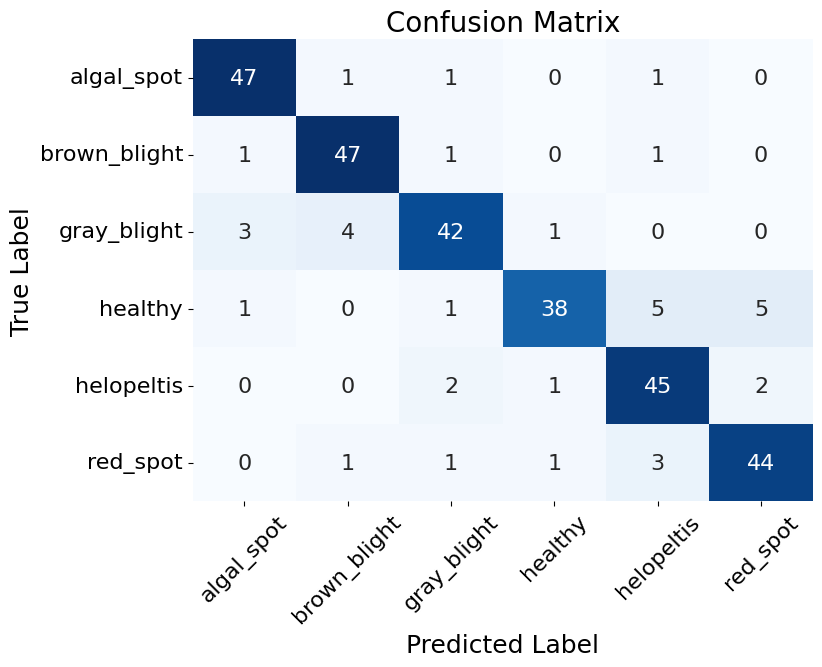

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9038    0.9400    0.9216        50
brown_blight     0.8868    0.9400    0.9126        50
 gray_blight     0.8750    0.8400    0.8571        50
     healthy     0.9268    0.7600    0.8352        50
  helopeltis     0.8182    0.9000    0.8571        50
    red_spot     0.8627    0.8800    0.8713        50

    accuracy                         0.8767       300
   macro avg     0.8789    0.8767    0.8758       300
weighted avg     0.8789    0.8767    0.8758       300

Accuracy: 0.8767
ROC AUC Score: 0.9876


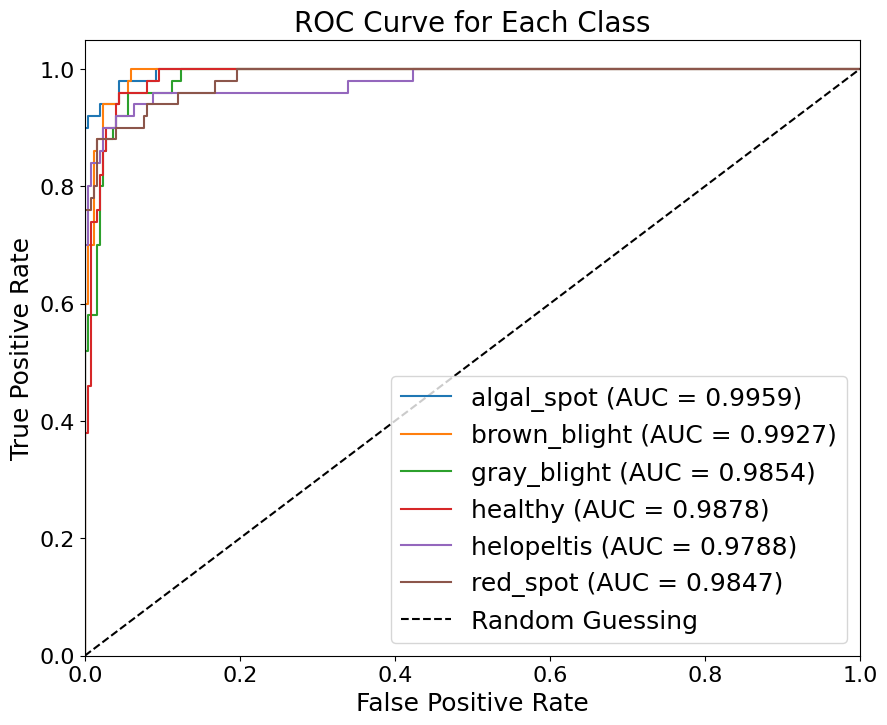

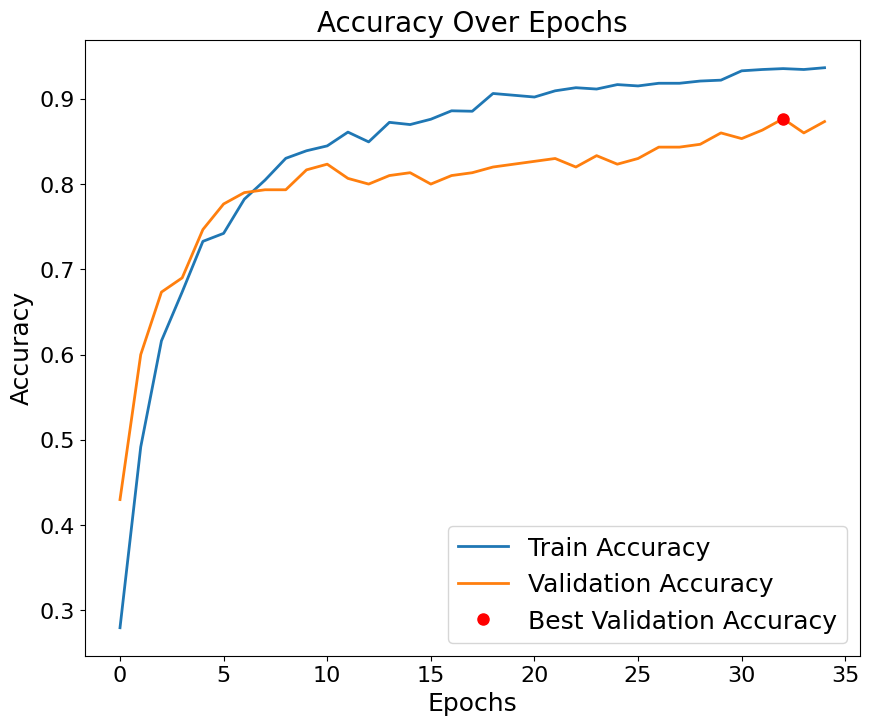

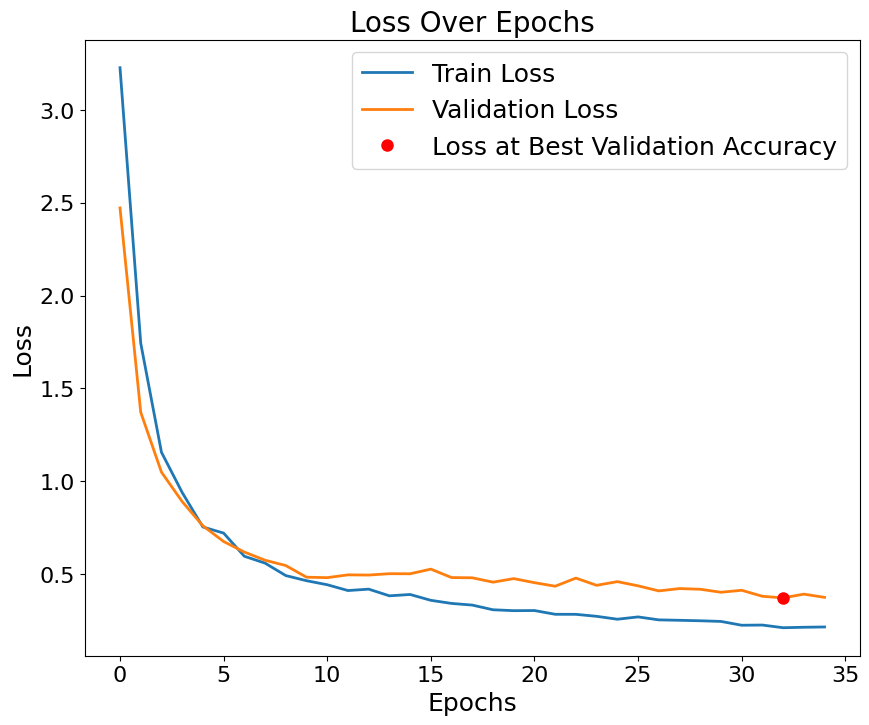

In [11]:
image_size = (224, 224)
model_name = 'VGG16' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

VGG16

In [13]:
base_val = 0

model_path = f'best_model_VGG16.keras'
model = tf.keras.models.load_model(model_path)

print("best_model_VGG16")
# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


best_model_VGG16
5/5 [==============================] - 1s 124ms/step - loss: 0.3712 - accuracy: 0.8767
Validation Accuracy: 0.8767
Validation Loss: 0.3712


VGG19

Found 5867 files belonging to 6 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 20,027,462
Trainable params: 3,078
Non-trainable params: 20,024,384
_________________________________________________________________
Epoch 1/35
     31/Unknown - 7s 226ms/step - loss: 2.8976 - accuracy: 0.2552
Epoch 1: val_accuracy improved from -inf to 0.43000, saving model to best_model_VGG19.keras
31/31 [===================

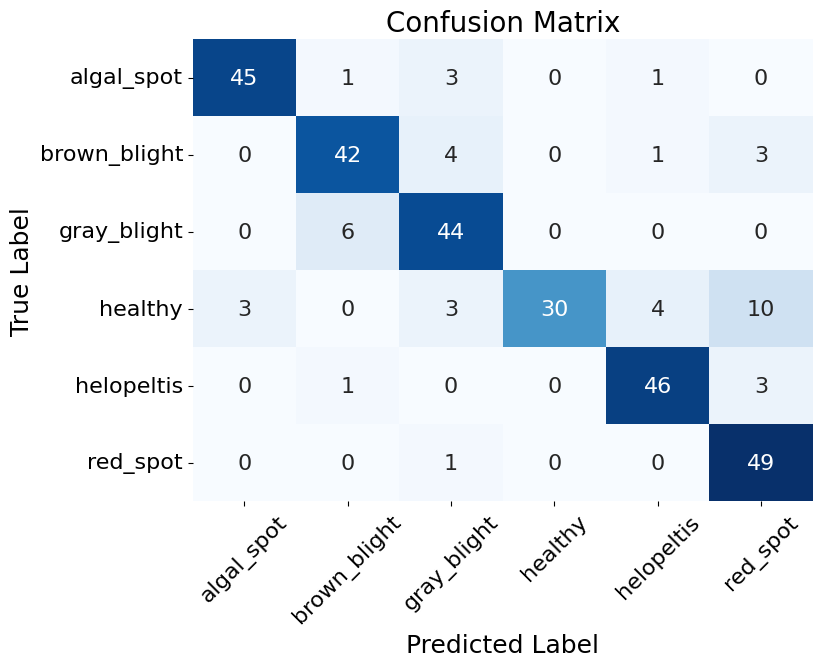

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9375    0.9000    0.9184        50
brown_blight     0.8400    0.8400    0.8400        50
 gray_blight     0.8000    0.8800    0.8381        50
     healthy     1.0000    0.6000    0.7500        50
  helopeltis     0.8846    0.9200    0.9020        50
    red_spot     0.7538    0.9800    0.8522        50

    accuracy                         0.8533       300
   macro avg     0.8693    0.8533    0.8501       300
weighted avg     0.8693    0.8533    0.8501       300

Accuracy: 0.8533
ROC AUC Score: 0.9889


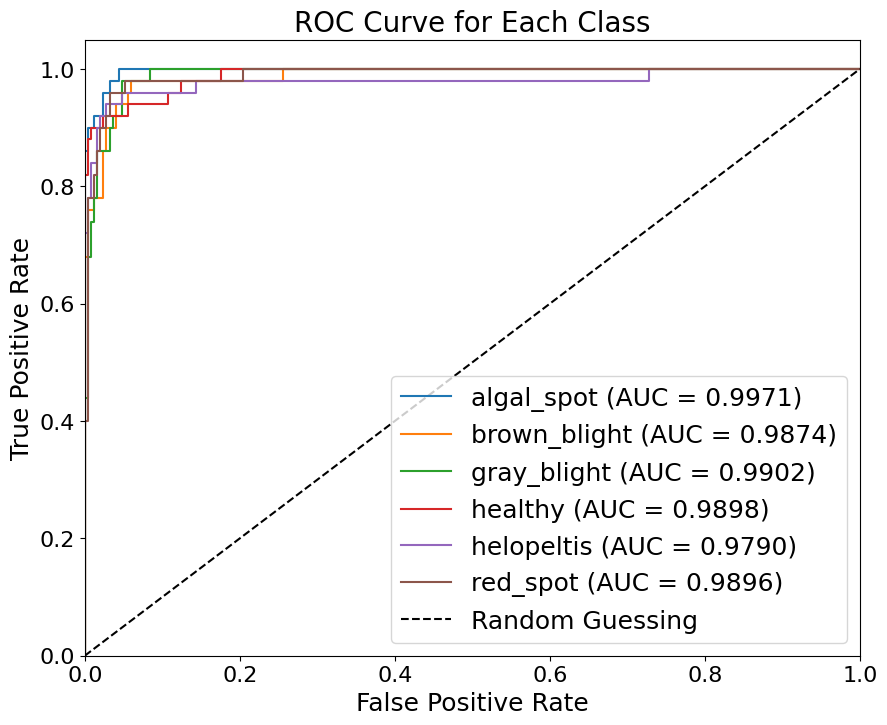

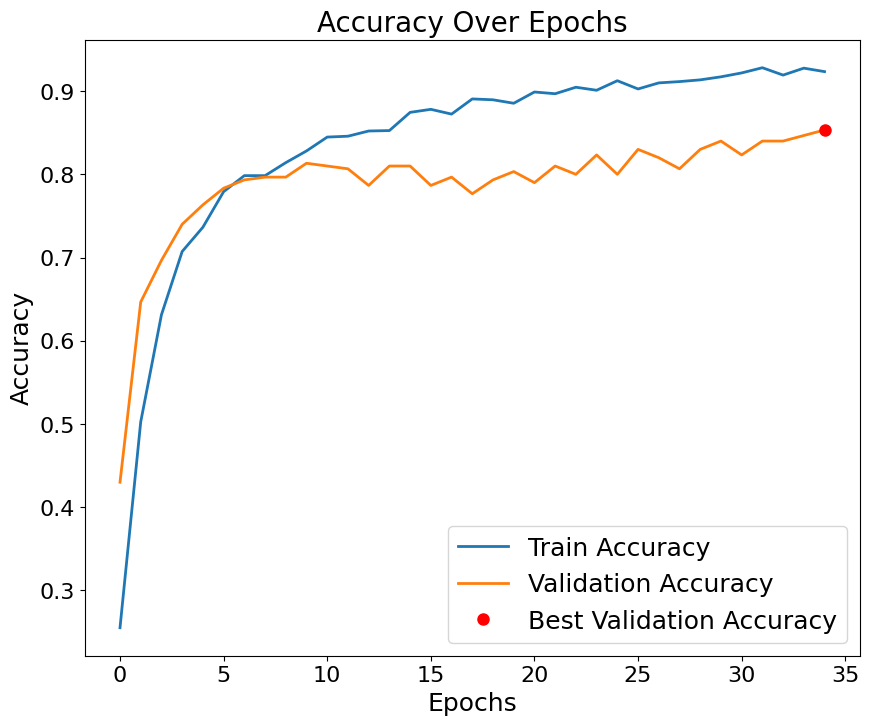

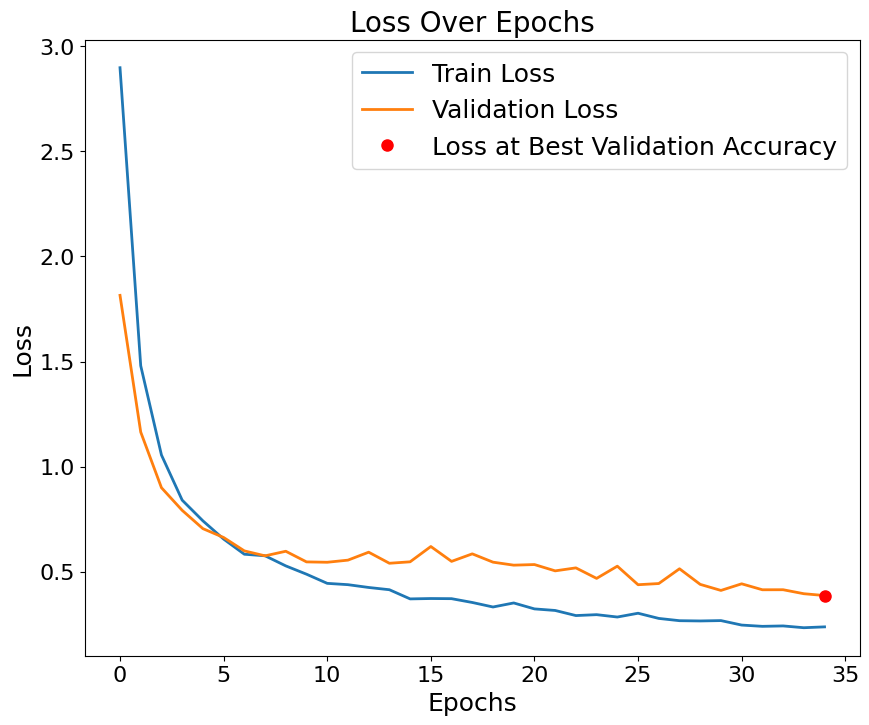

In [14]:
image_size = (224, 224)
model_name = 'VGG19' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

In [15]:
base_val = 0

model_path = f'best_model_VGG19.keras'
model = tf.keras.models.load_model(model_path)

print("best_model_VGG19")
# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


best_model_VGG19
5/5 [==============================] - 1s 116ms/step - loss: 0.3867 - accuracy: 0.8533
Validation Accuracy: 0.8533
Validation Loss: 0.3867


Mobile Net

Found 5867 files belonging to 6 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 6150      
                                                                 
Total params: 3,235,014
Trainable params: 6,150
Non-trainable params: 3,228,864
_________________________________________________________________
Epoch 1/35
     31/Unknown - 5s 141ms/step - loss: 1.7535 - accuracy: 0.3172
Epoch 1: val_accuracy improved from -inf to 0.49000, s

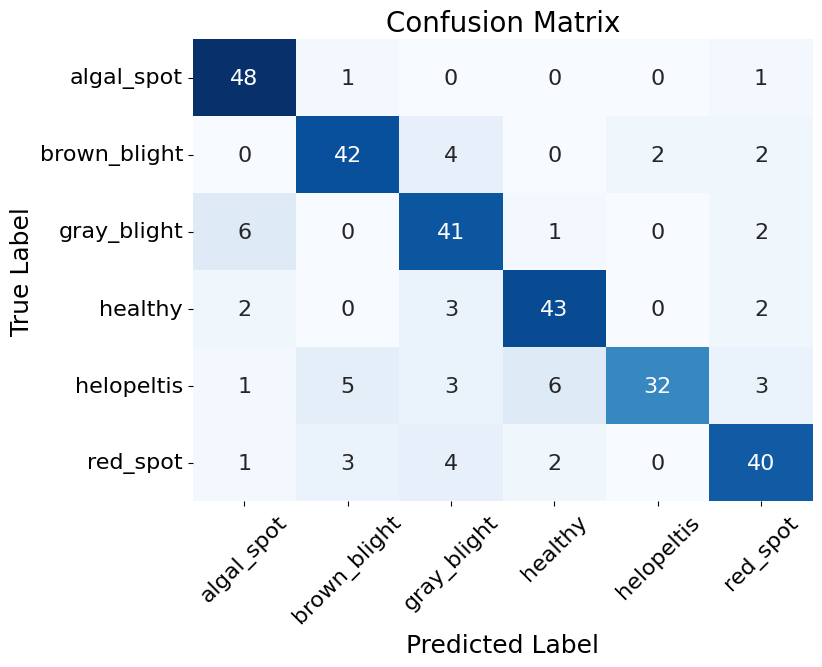

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.8276    0.9600    0.8889        50
brown_blight     0.8235    0.8400    0.8317        50
 gray_blight     0.7455    0.8200    0.7810        50
     healthy     0.8269    0.8600    0.8431        50
  helopeltis     0.9412    0.6400    0.7619        50
    red_spot     0.8000    0.8000    0.8000        50

    accuracy                         0.8200       300
   macro avg     0.8274    0.8200    0.8178       300
weighted avg     0.8274    0.8200    0.8178       300

Accuracy: 0.8200
ROC AUC Score: 0.9714


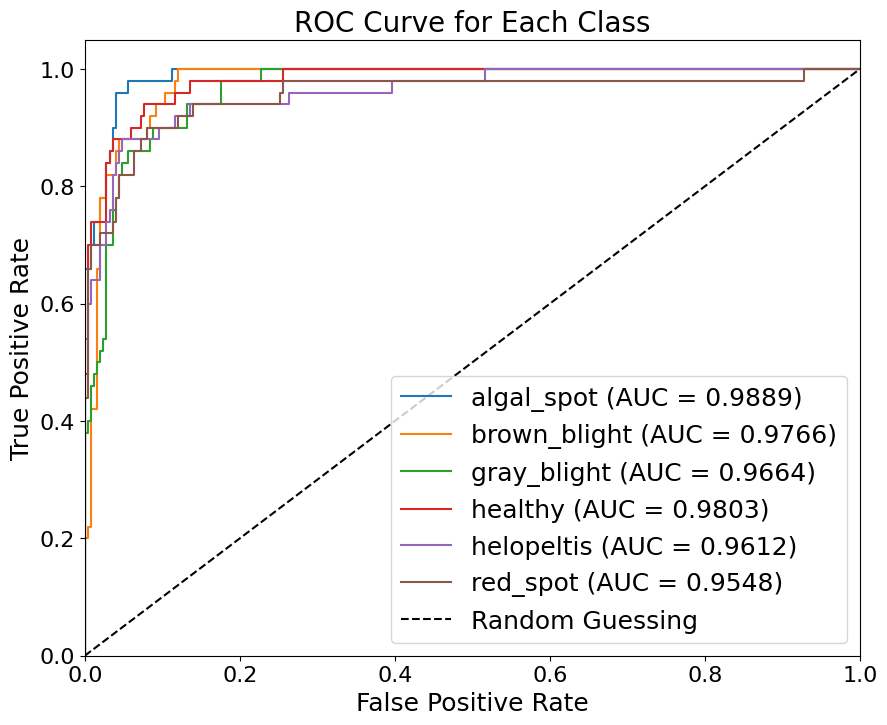

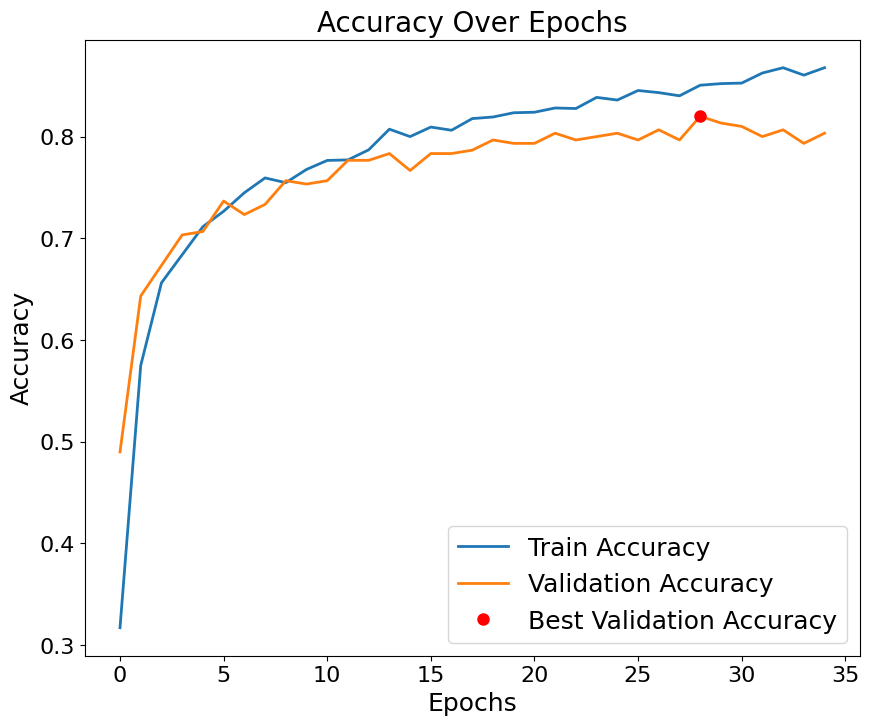

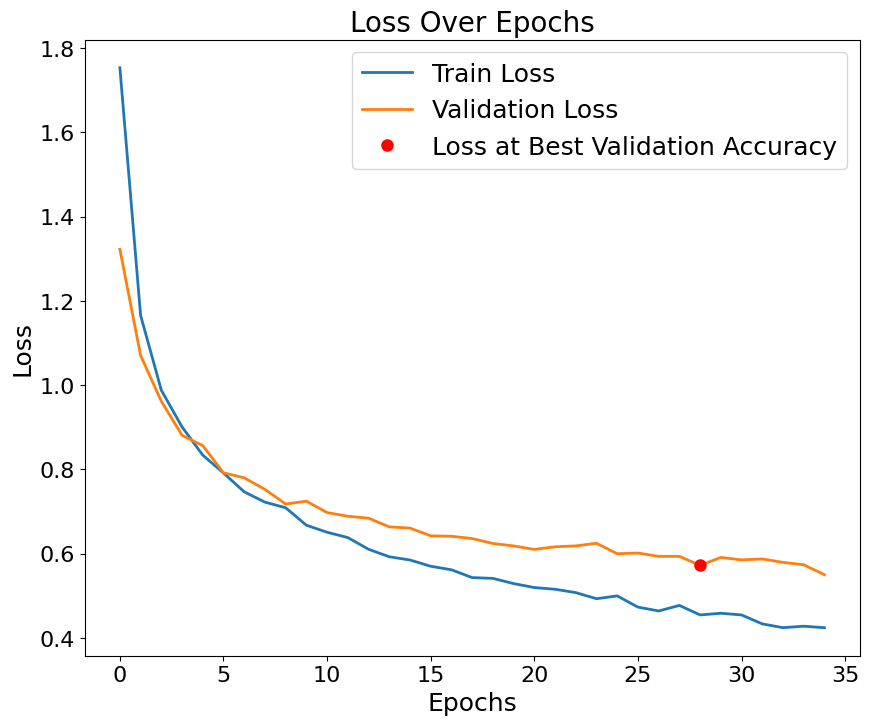

In [16]:
image_size = (224, 224)
model_name = 'MobileNet' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

In [17]:
base_val = 0

model_path = f'best_model_MobileNet.keras'
model = tf.keras.models.load_model(model_path)

print("best_model_MobileNet")
# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


best_model_MobileNet
5/5 [==============================] - 0s 25ms/step - loss: 0.5723 - accuracy: 0.8200
Validation Accuracy: 0.8200
Validation Loss: 0.5723


ResNet50

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________
Epoch 1/35
     31/Unknown - 7s 178ms/step - loss: 1.2986 - accuracy: 0.5208
Epoch 1: val_accuracy improved from -inf to 0.74333, saving model to best_model_ResNet50.keras
31/31 [=================

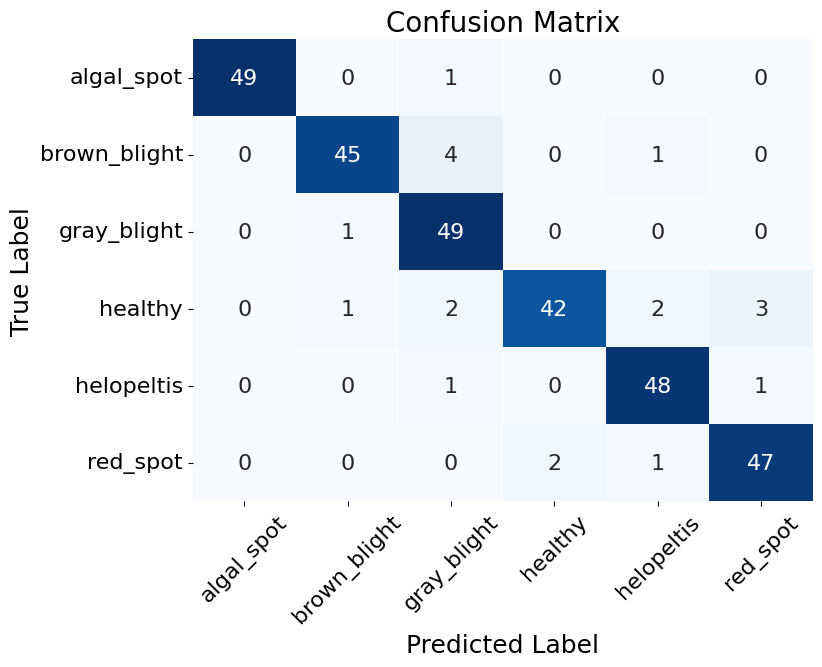

Classification Report:
              precision    recall  f1-score   support

  algal_spot     1.0000    0.9800    0.9899        50
brown_blight     0.9574    0.9000    0.9278        50
 gray_blight     0.8596    0.9800    0.9159        50
     healthy     0.9545    0.8400    0.8936        50
  helopeltis     0.9231    0.9600    0.9412        50
    red_spot     0.9216    0.9400    0.9307        50

    accuracy                         0.9333       300
   macro avg     0.9360    0.9333    0.9332       300
weighted avg     0.9360    0.9333    0.9332       300

Accuracy: 0.9333
ROC AUC Score: 0.9946


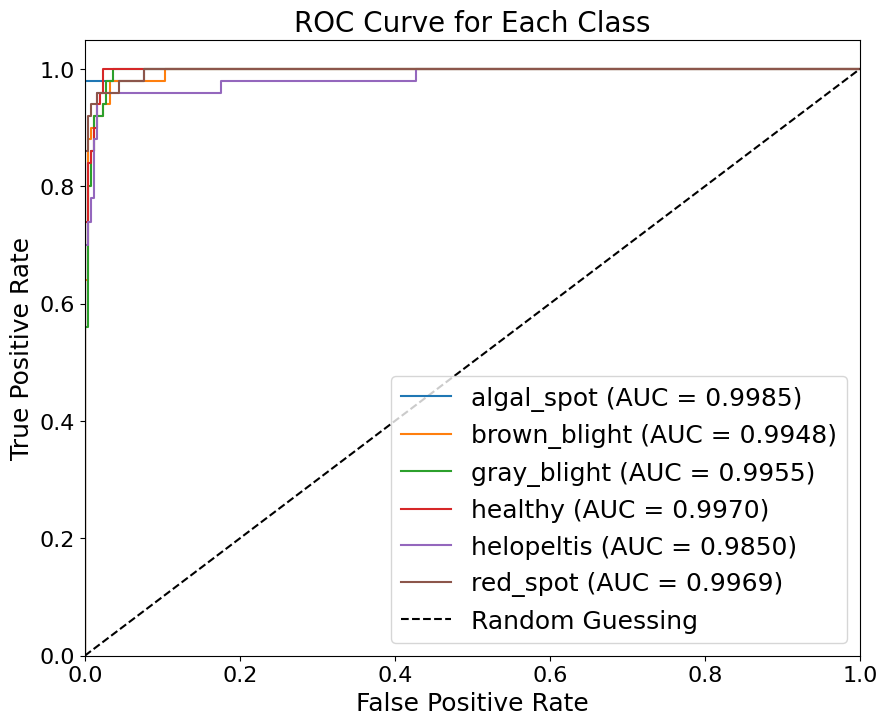

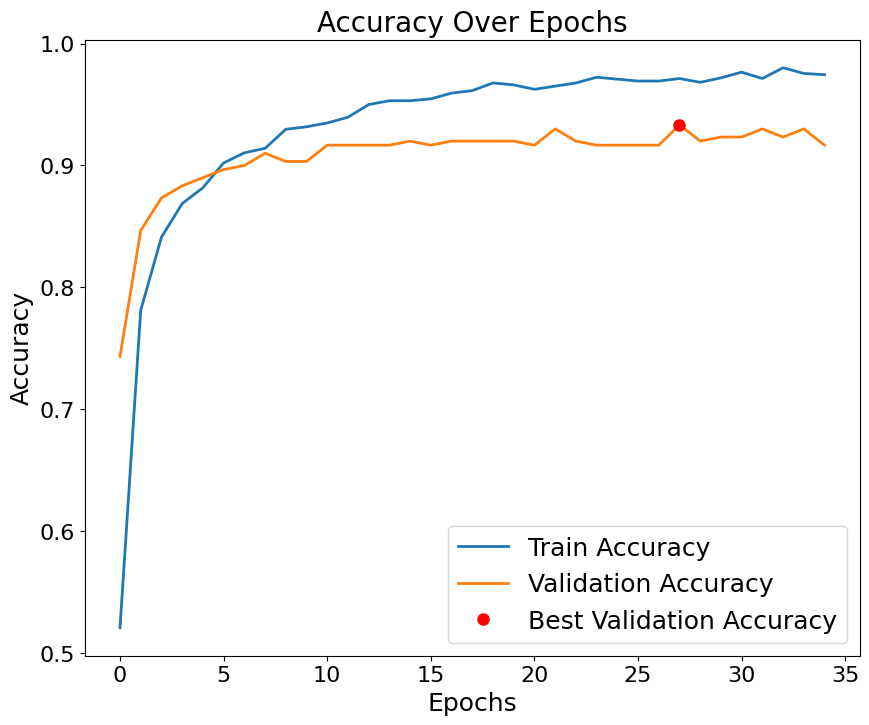

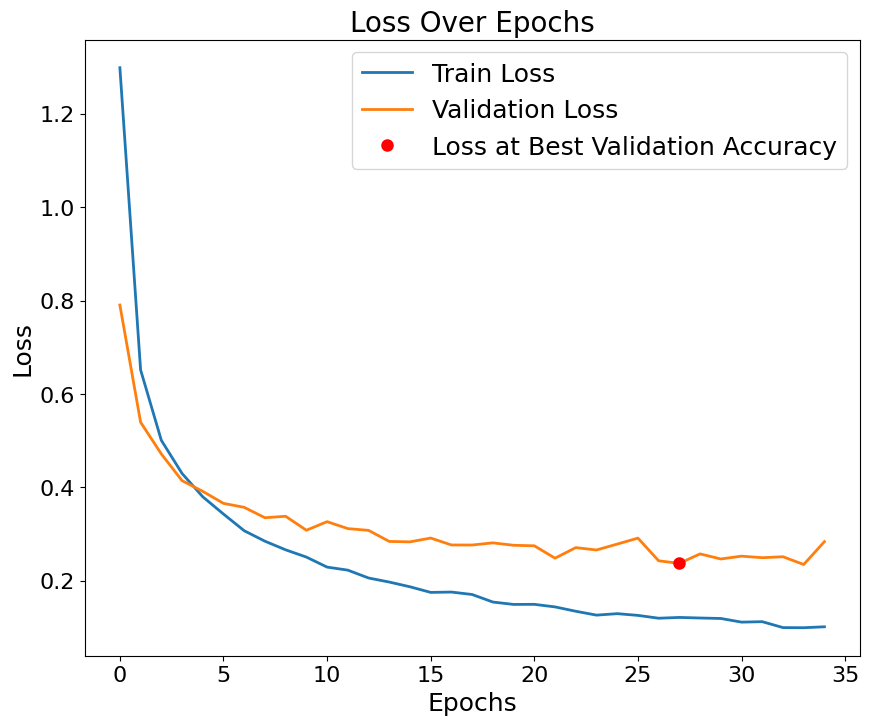

In [12]:
image_size = (224, 224)
model_name = 'ResNet50' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 global_average_pooling2d_1   (None, 1920)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 11526     
                                                                 
Total params: 18,333,510
Trainable params: 11,526
Non-trainable params: 18,321,984
_________________________________________________________________
Epoch 1/35
     30/Unknown - 9s 105ms/step - loss: 2.9320 - accuracy: 0.2873
Epoch 1: val_accuracy improved from -inf to 0.35333, saving model to best_model_DenseNet201.keras
31/31 [============

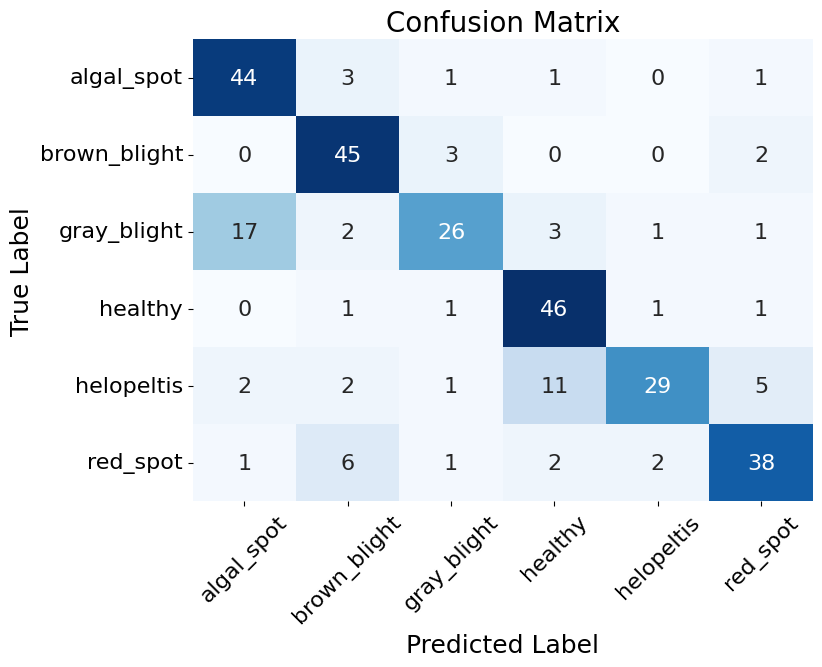

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.6875    0.8800    0.7719        50
brown_blight     0.7627    0.9000    0.8257        50
 gray_blight     0.7879    0.5200    0.6265        50
     healthy     0.7302    0.9200    0.8142        50
  helopeltis     0.8788    0.5800    0.6988        50
    red_spot     0.7917    0.7600    0.7755        50

    accuracy                         0.7600       300
   macro avg     0.7731    0.7600    0.7521       300
weighted avg     0.7731    0.7600    0.7521       300

Accuracy: 0.7600
ROC AUC Score: 0.9631


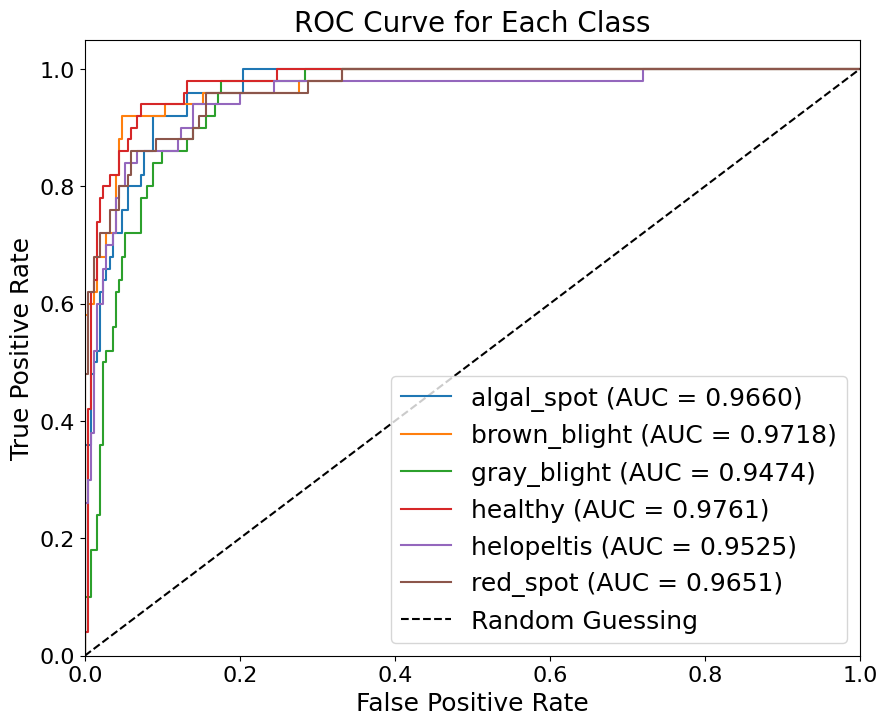

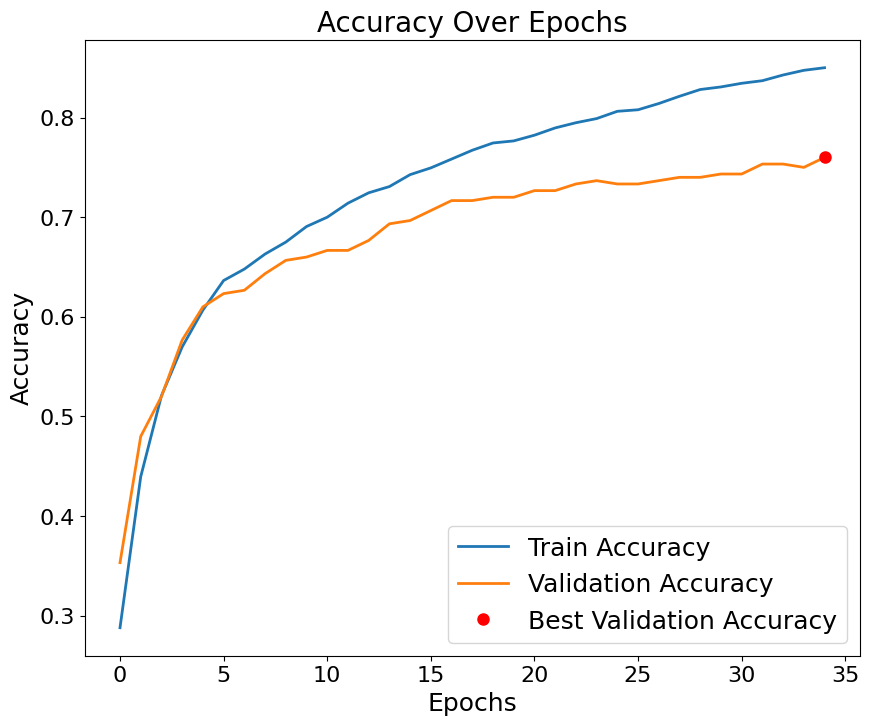

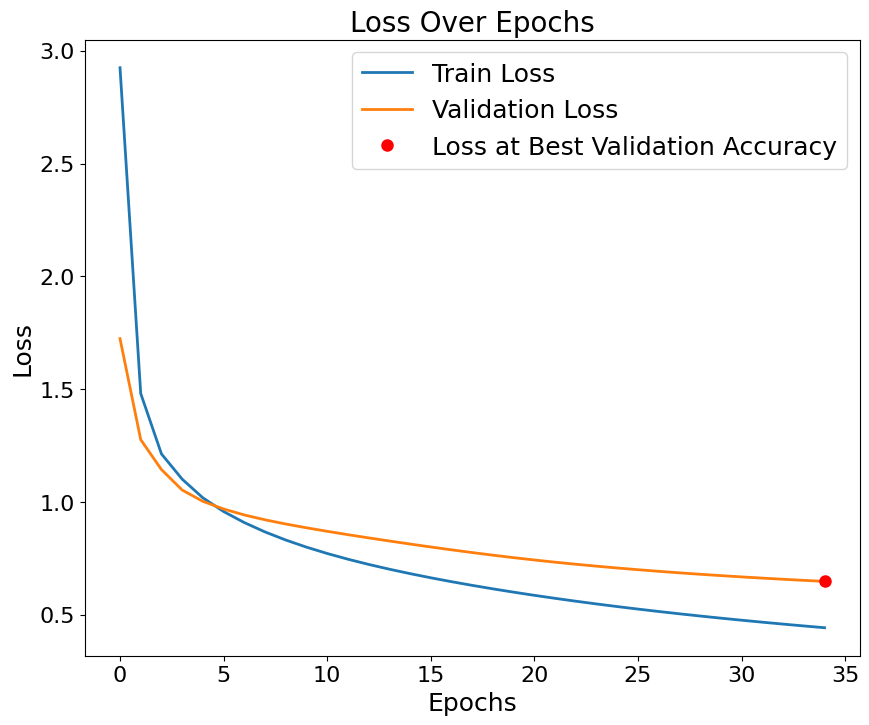

In [14]:
image_size = (224, 224)
model_name = 'DenseNet201' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________
Epoch 1/35
     31/Unknown - 4s 52ms/step - loss: 23.7064 - accuracy: 0.2094
Epoch 1: val_accuracy improved from -inf to 0.24333, saving model to best_model_InceptionV3.keras
31/31 [============

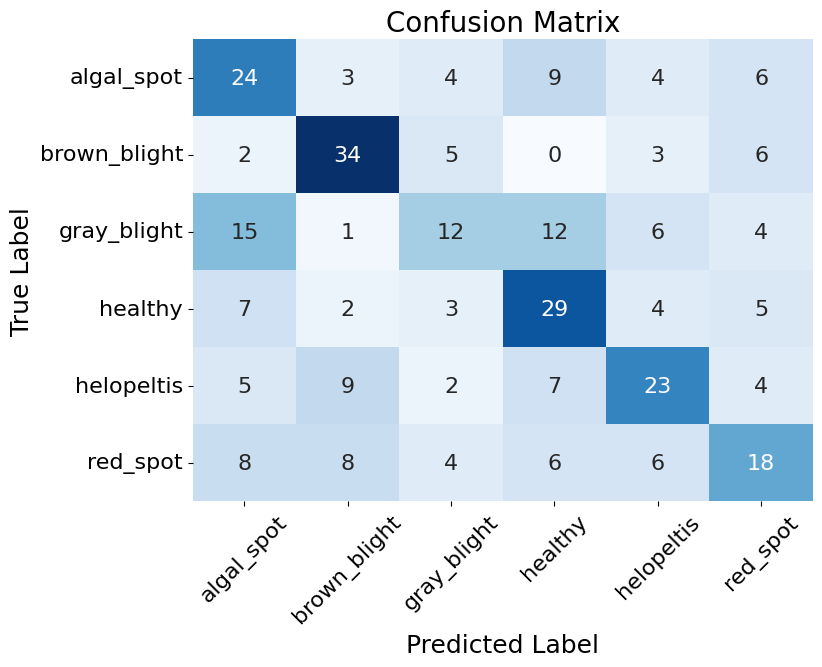

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.3934    0.4800    0.4324        50
brown_blight     0.5965    0.6800    0.6355        50
 gray_blight     0.4000    0.2400    0.3000        50
     healthy     0.4603    0.5800    0.5133        50
  helopeltis     0.5000    0.4600    0.4792        50
    red_spot     0.4186    0.3600    0.3871        50

    accuracy                         0.4667       300
   macro avg     0.4615    0.4667    0.4579       300
weighted avg     0.4615    0.4667    0.4579       300

Accuracy: 0.4667
ROC AUC Score: 0.7886


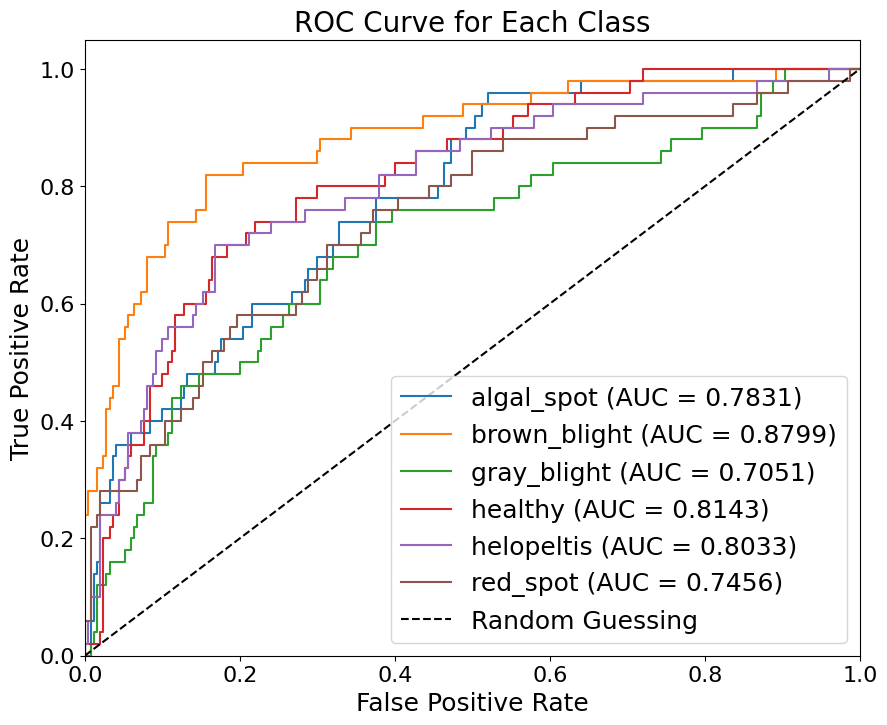

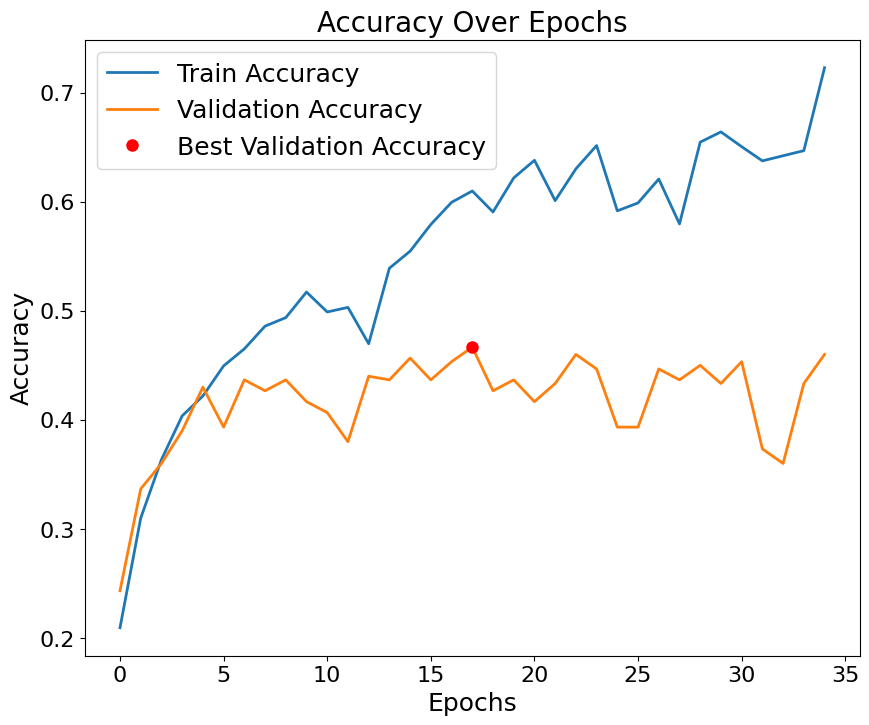

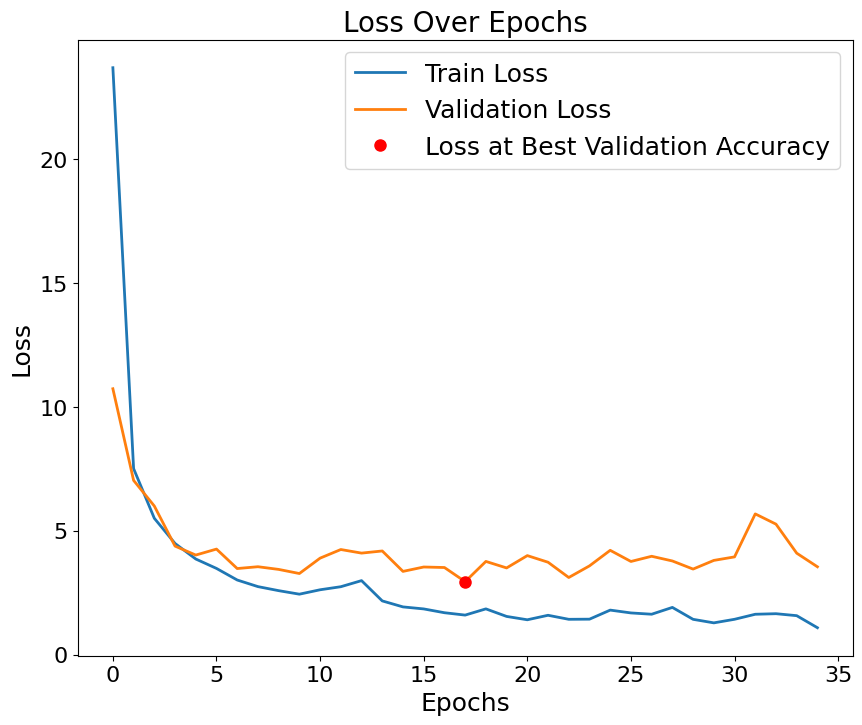

In [15]:
image_size = (224, 224)
model_name = 'InceptionV3' #224 input
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 5,926,998
Trainable params: 7,686
Non-trainable params: 5,919,312
_________________________________________________________________
Epoch 1/35
     30/Unknown - 4s 38ms/step - loss: 1.2912 - accuracy: 0.5641
Epoch 1: val_accuracy improved from -inf to 0.78000, sa

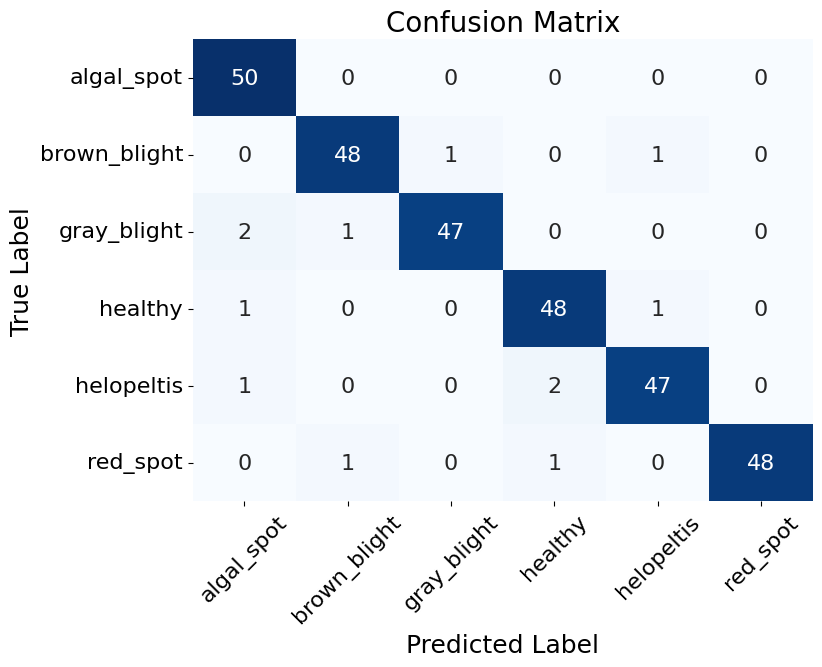

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9259    1.0000    0.9615        50
brown_blight     0.9600    0.9600    0.9600        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9412    0.9600    0.9505        50
  helopeltis     0.9592    0.9400    0.9495        50
    red_spot     1.0000    0.9600    0.9796        50

    accuracy                         0.9600       300
   macro avg     0.9609    0.9600    0.9601       300
weighted avg     0.9609    0.9600    0.9601       300

Accuracy: 0.9600
ROC AUC Score: 0.9970


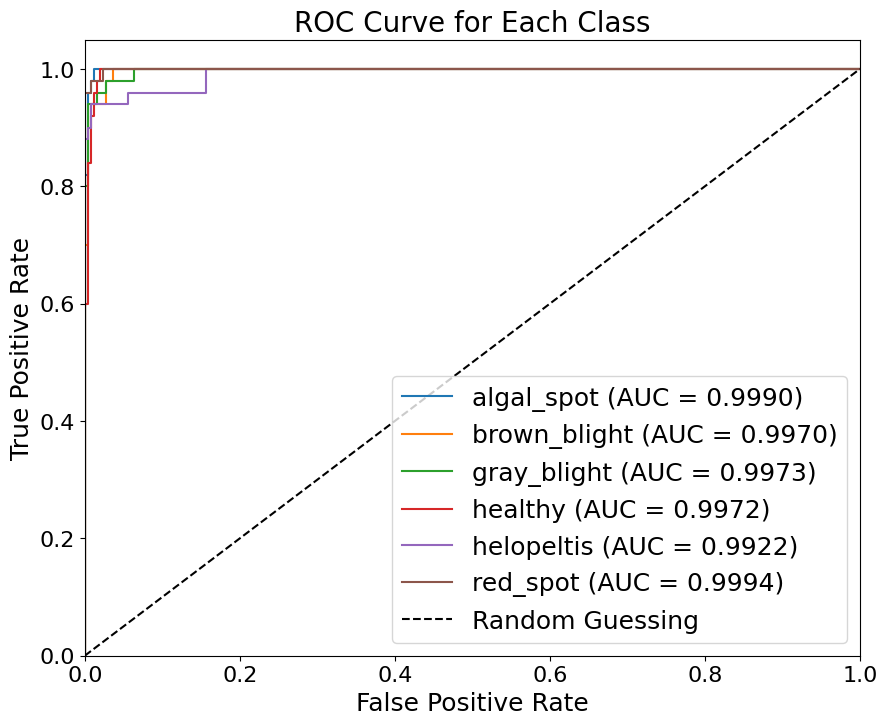

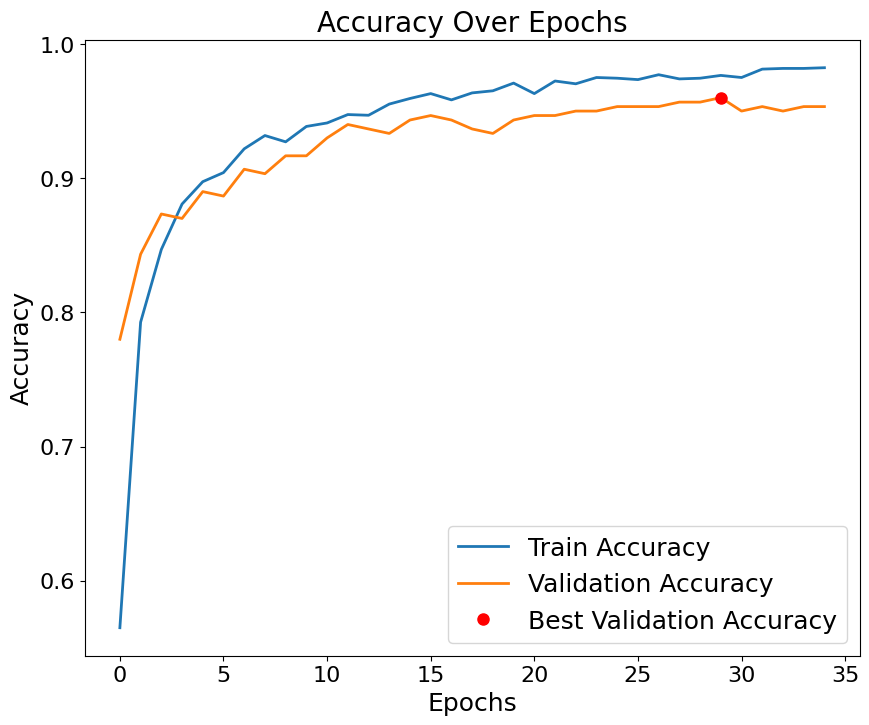

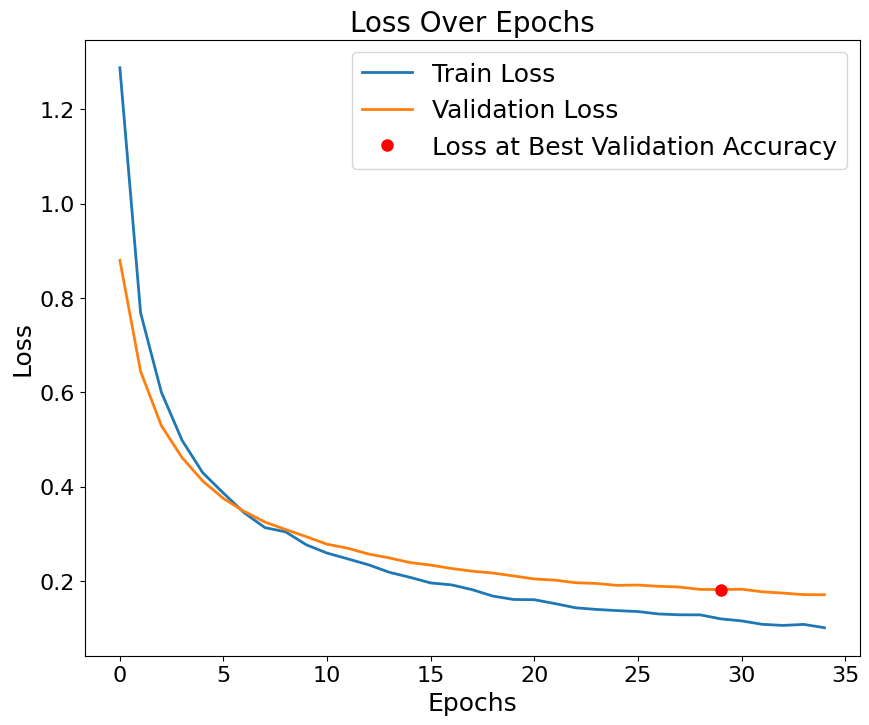

In [19]:
image_size = (224, 224)
model_name = 'EfficientNetV2B0'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 8, 8, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_4   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 8454      
                                                                 
Total params: 8,777,828
Trainable params: 8,454
Non-trainable params: 8,769,374
_________________________________________________________________
Epoch 1/35
     31/Unknown - 6s 62ms/step - loss: 1.2620 - accuracy: 0.5797
Epoch 1: val_accuracy improved from -inf to 0.79000, sa

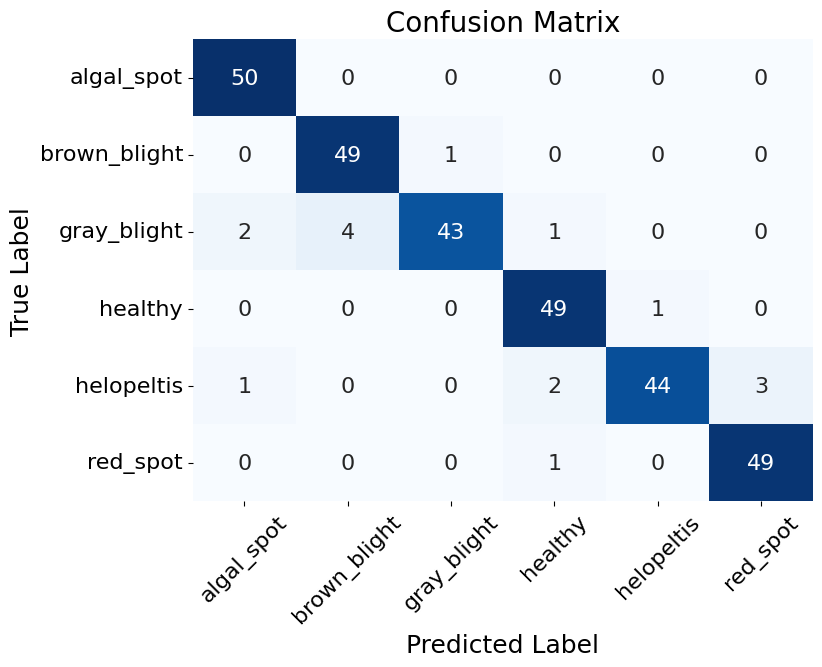

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9434    1.0000    0.9709        50
brown_blight     0.9245    0.9800    0.9515        50
 gray_blight     0.9773    0.8600    0.9149        50
     healthy     0.9245    0.9800    0.9515        50
  helopeltis     0.9778    0.8800    0.9263        50
    red_spot     0.9423    0.9800    0.9608        50

    accuracy                         0.9467       300
   macro avg     0.9483    0.9467    0.9460       300
weighted avg     0.9483    0.9467    0.9460       300

Accuracy: 0.9467
ROC AUC Score: 0.9936


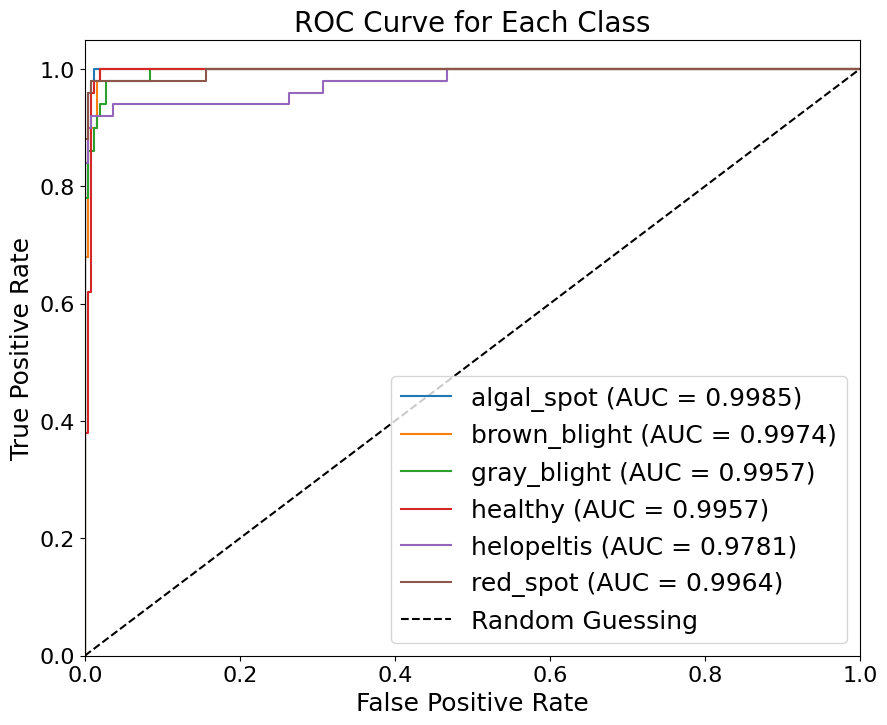

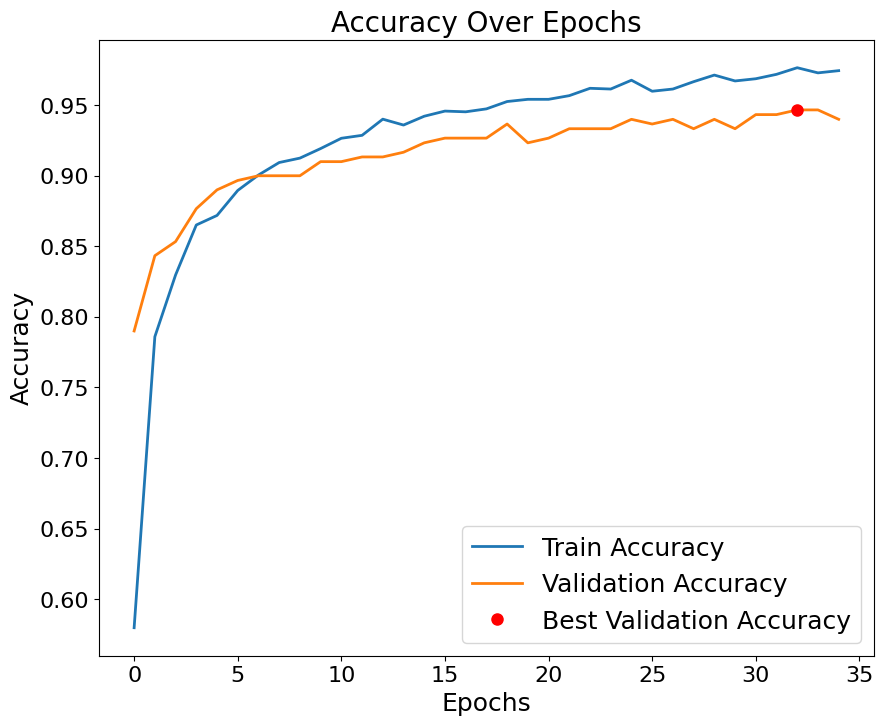

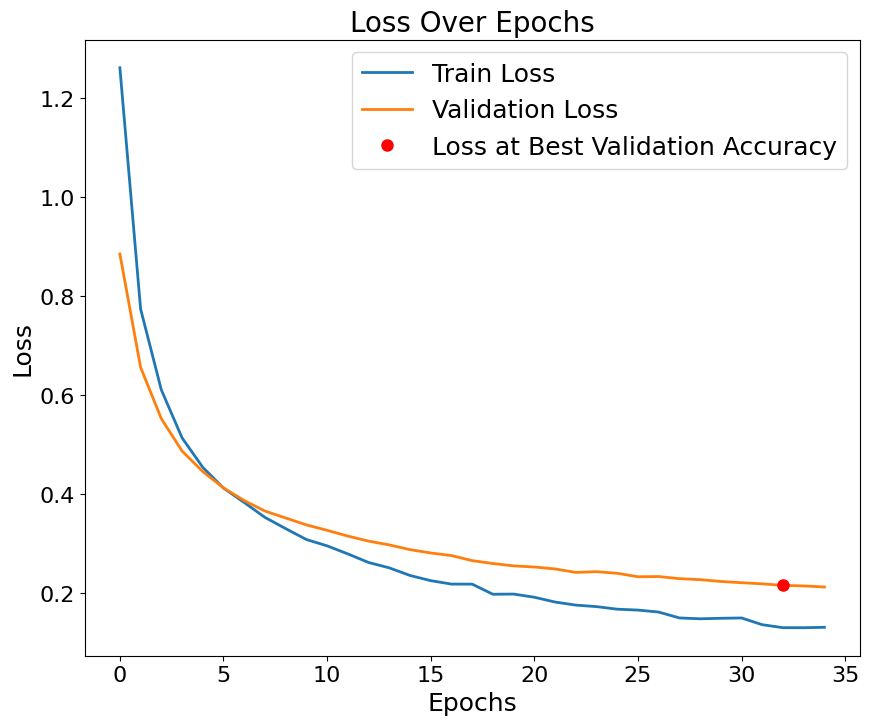

In [20]:
image_size = (240, 240)
model_name = 'EfficientNetV2B1'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b2 (Function  (None, 9, 9, 1408)       8769374   
 al)                                                             
                                                                 
 global_average_pooling2d_3   (None, 1408)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_3 (Dense)             (None, 6)                 8454      
                                                                 
Total params: 8,777,828
Trainable params: 8,454
Non-trainable params: 8,769,374
_________________________________________________________________
Epoch 1/35
     31/Unknown - 7s 93ms/step - loss: 1.3409 - accuracy: 0.5312
Epoch 1: val_accuracy improved from -inf to 0.78667, sa

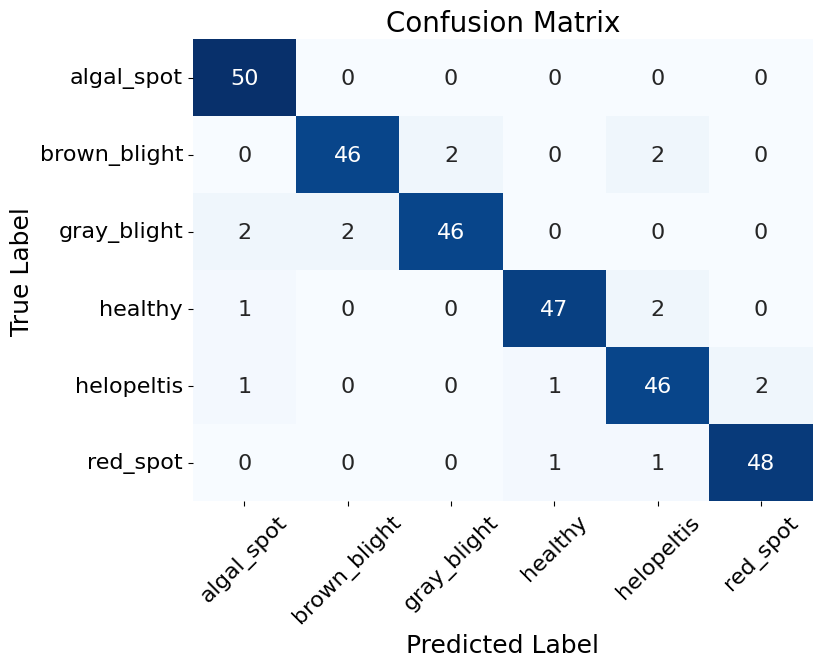

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9259    1.0000    0.9615        50
brown_blight     0.9583    0.9200    0.9388        50
 gray_blight     0.9583    0.9200    0.9388        50
     healthy     0.9592    0.9400    0.9495        50
  helopeltis     0.9020    0.9200    0.9109        50
    red_spot     0.9600    0.9600    0.9600        50

    accuracy                         0.9433       300
   macro avg     0.9440    0.9433    0.9432       300
weighted avg     0.9440    0.9433    0.9432       300

Accuracy: 0.9433
ROC AUC Score: 0.9947


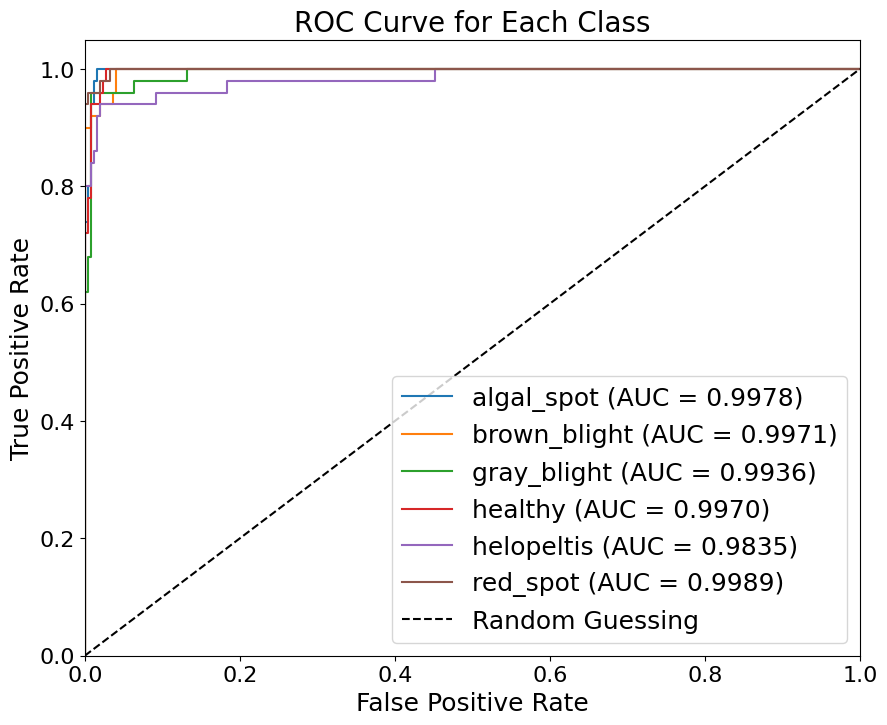

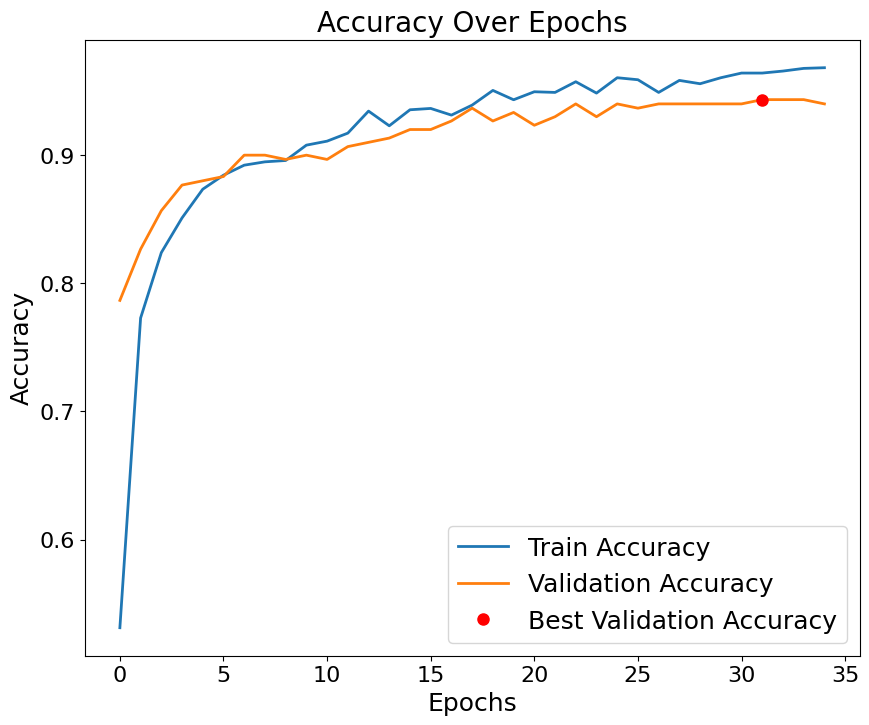

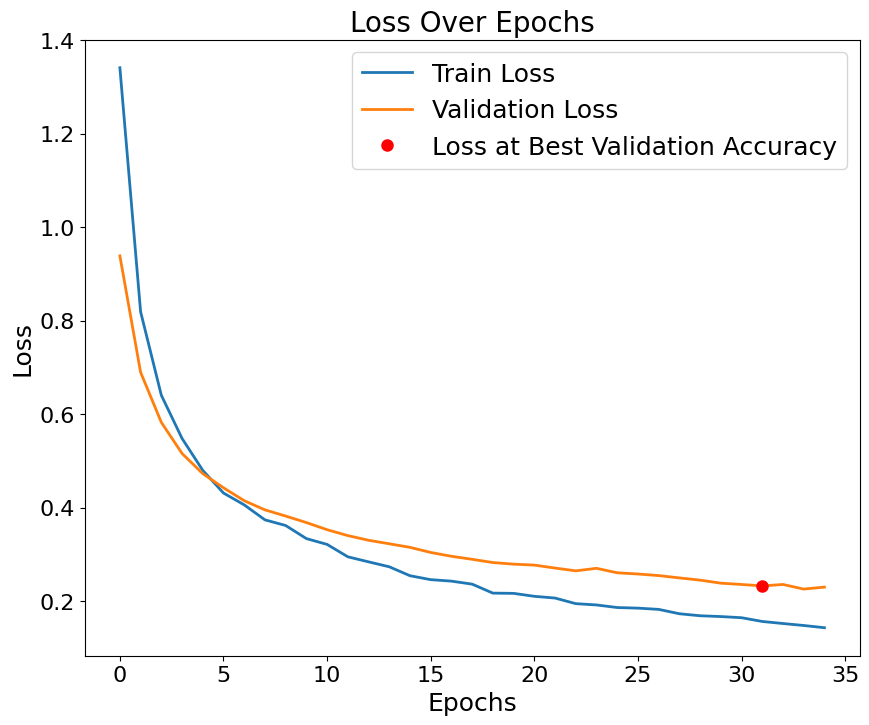

In [ ]:
image_size = (260, 260)
model_name = 'EfficientNetV2B2'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

In [19]:
base_val = 0

model_path = f'best_model_EfficientNetV2B2.keras'
model = tf.keras.models.load_model(model_path)

print("best_model_EfficientNetV2B2")
# Evaluasi model pada data validasi
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Loss: {val_loss:.4f}")


best_model_EfficientNetV2B2
5/5 [==============================] - 1s 70ms/step - loss: 0.2328 - accuracy: 0.9433
Validation Accuracy: 0.9433
Validation Loss: 0.2328


Found 5867 files belonging to 6 classes.
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b3 (Function  (None, 10, 10, 1536)     12930622  
 al)                                                             
                                                                 
 global_average_pooling2d_5   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_5 (Dense)             (None, 6)                 9222      
                                                                 
Total params: 12,939,844
Trainable params: 9,222
Non-trainable params: 12,930,622
_________________________________________________________________
Epoch 1/35
     30/Unknown - 10s 135ms/step - loss: 1.3208 - accuracy: 0.5257
Epoch 1: val_accuracy improved from -inf to 0.74667

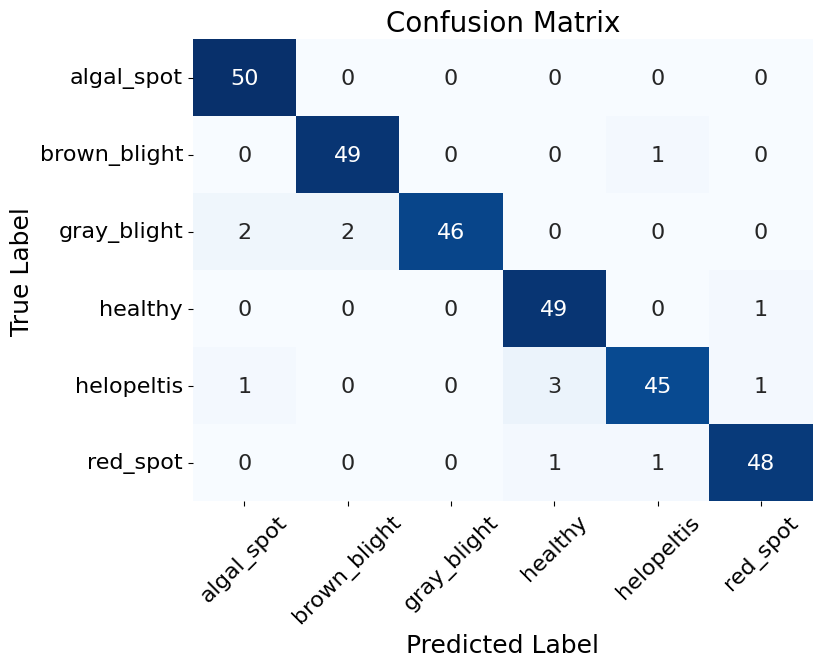

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9434    1.0000    0.9709        50
brown_blight     0.9608    0.9800    0.9703        50
 gray_blight     1.0000    0.9200    0.9583        50
     healthy     0.9245    0.9800    0.9515        50
  helopeltis     0.9574    0.9000    0.9278        50
    red_spot     0.9600    0.9600    0.9600        50

    accuracy                         0.9567       300
   macro avg     0.9577    0.9567    0.9565       300
weighted avg     0.9577    0.9567    0.9565       300

Accuracy: 0.9567
ROC AUC Score: 0.9960


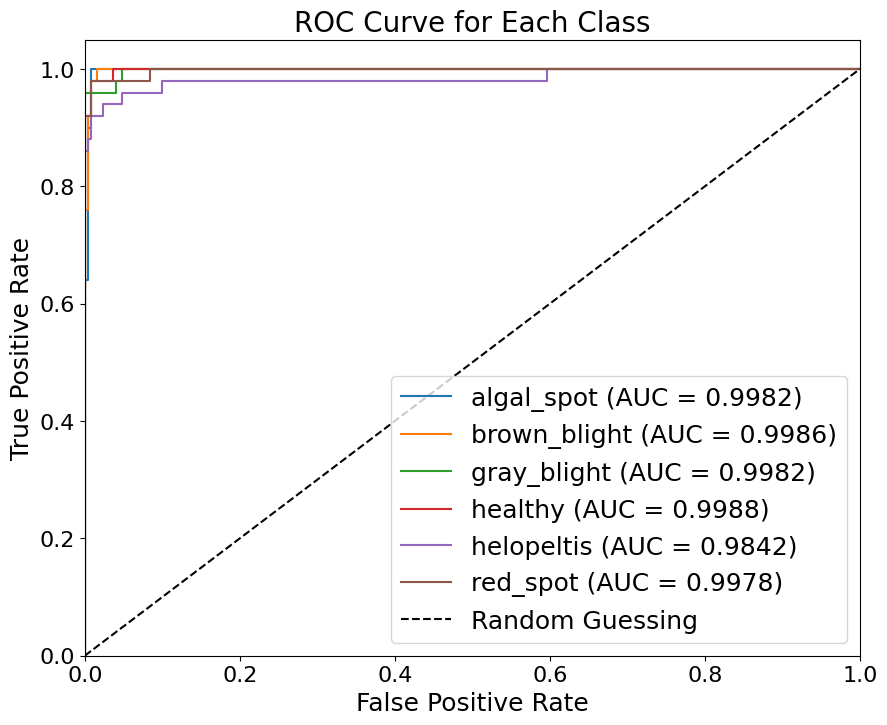

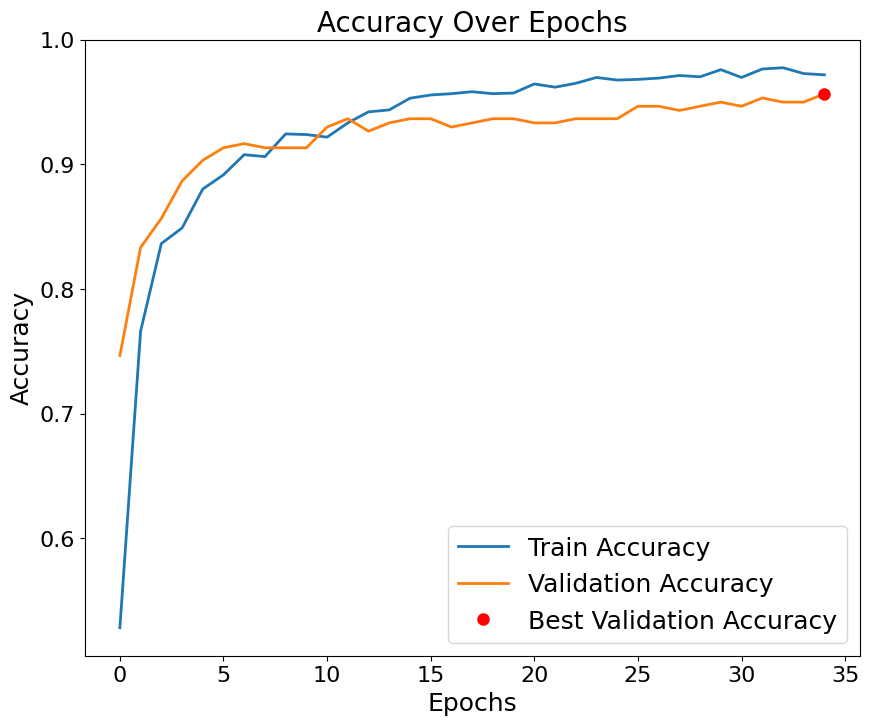

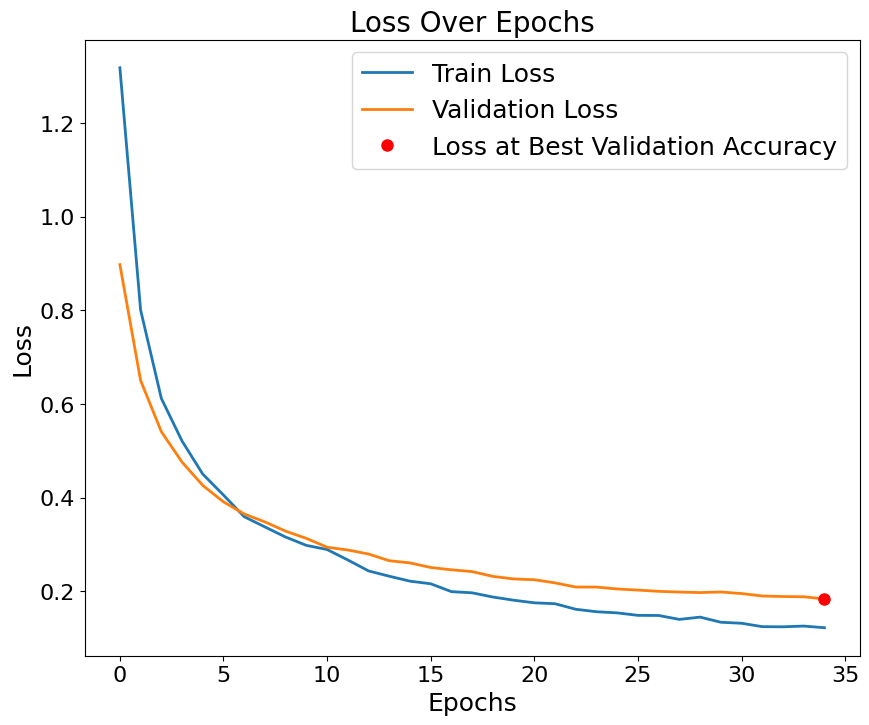

In [21]:
image_size = (300, 300)
model_name = 'EfficientNetV2B3'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 12, 12, 1280)     20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 7686      
                                                                 
Total params: 20,339,046
Trainable params: 7,686
Non-trainable params: 20,331,360
_________________________________________________________________
Epoch 1/35
     31/Unknown - 31s 745ms/step - loss: 1.4591 - accuracy: 0.4688
Epoch 1: val_accuracy improved from -inf to 0.74667, 

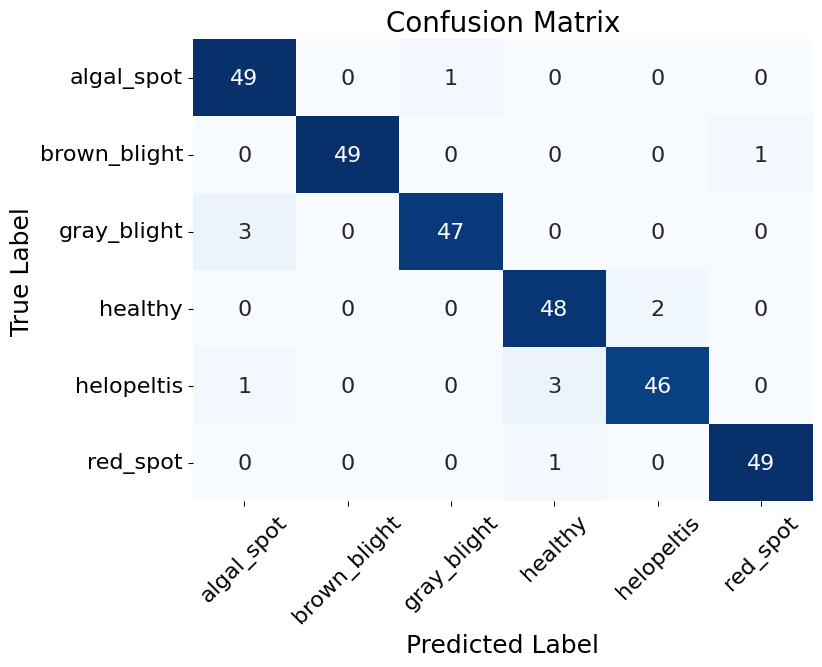

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9245    0.9800    0.9515        50
brown_blight     1.0000    0.9800    0.9899        50
 gray_blight     0.9792    0.9400    0.9592        50
     healthy     0.9231    0.9600    0.9412        50
  helopeltis     0.9583    0.9200    0.9388        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9600       300
   macro avg     0.9609    0.9600    0.9601       300
weighted avg     0.9609    0.9600    0.9601       300

Accuracy: 0.9600
ROC AUC Score: 0.9930


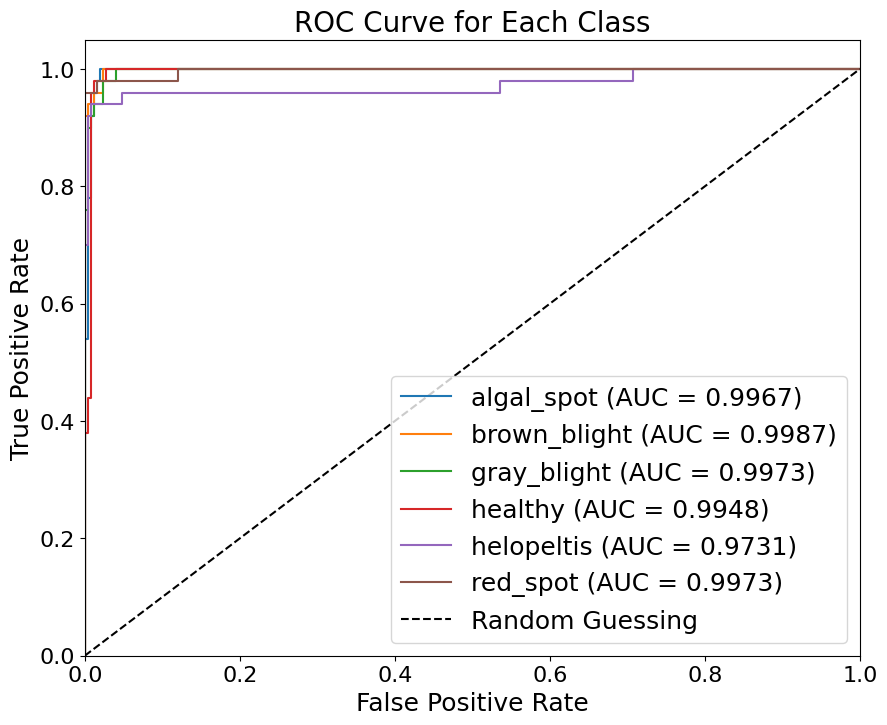

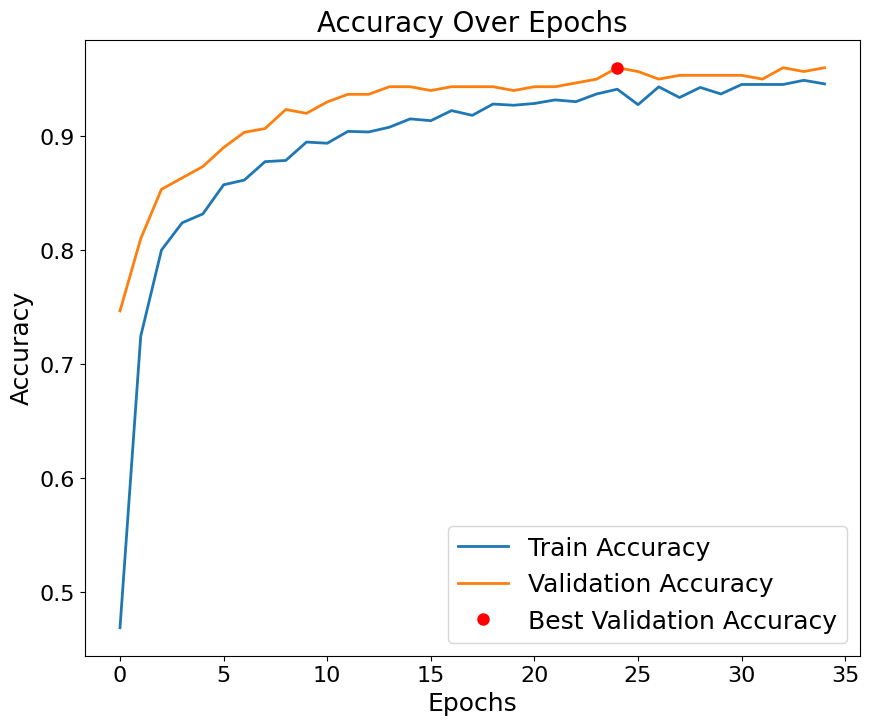

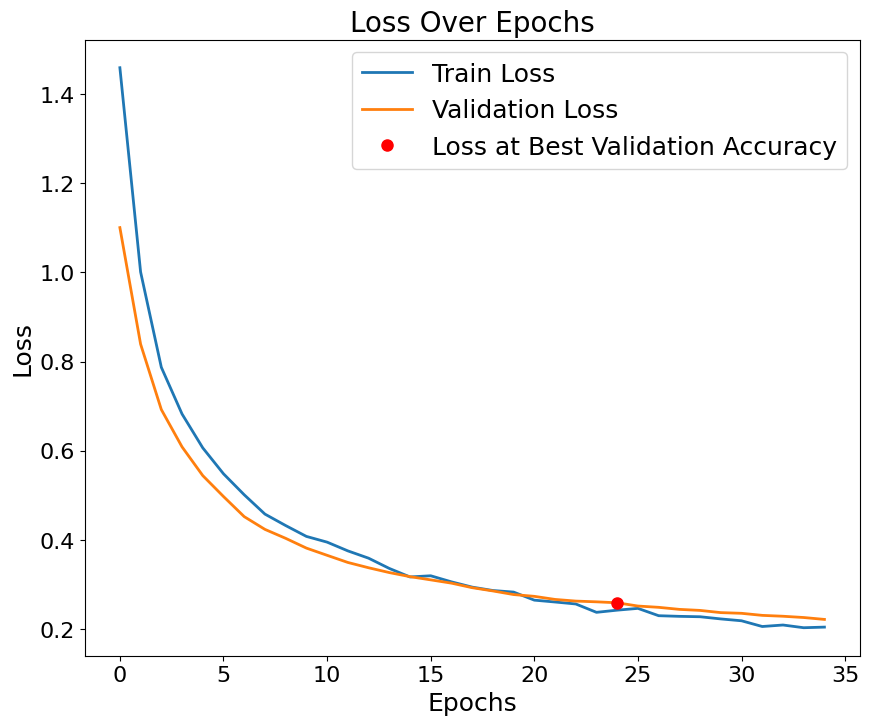

In [12]:
image_size = (384, 384)
model_name = 'EfficientNetV2S'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-m (Functiona  (None, 15, 15, 1280)     53150388  
 l)                                                              
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 6)                 7686      
                                                                 
Total params: 53,158,074
Trainable params: 7,686
Non-trainable params: 53,150,388
_________________________________________________________________
Epoch 1/35
     31/Unknown - 30s 680ms/step - loss: 1.4711 - accuracy: 0.5073
Epoch 1: val_accuracy improved from -inf to 0.71667

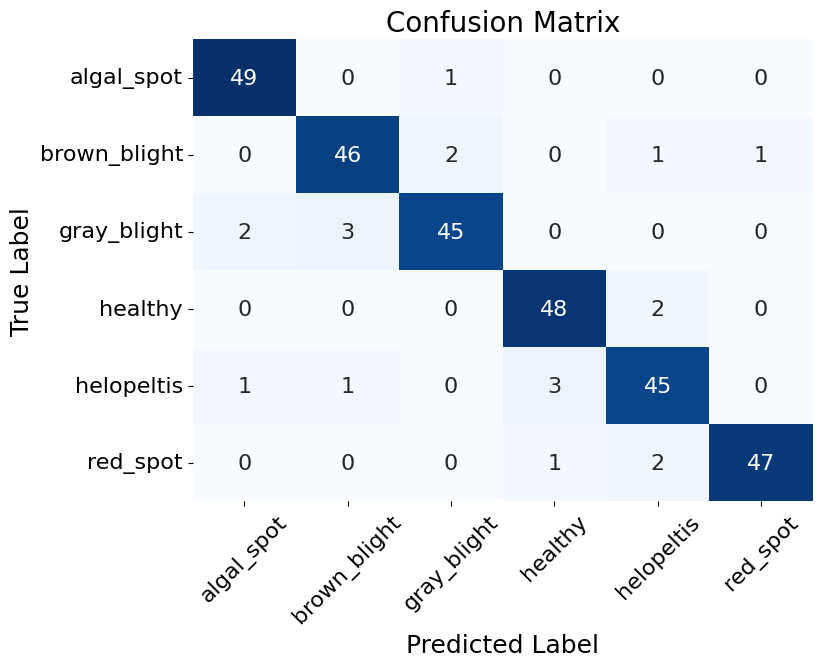

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9423    0.9800    0.9608        50
brown_blight     0.9200    0.9200    0.9200        50
 gray_blight     0.9375    0.9000    0.9184        50
     healthy     0.9231    0.9600    0.9412        50
  helopeltis     0.9000    0.9000    0.9000        50
    red_spot     0.9792    0.9400    0.9592        50

    accuracy                         0.9333       300
   macro avg     0.9337    0.9333    0.9333       300
weighted avg     0.9337    0.9333    0.9333       300

Accuracy: 0.9333
ROC AUC Score: 0.9922


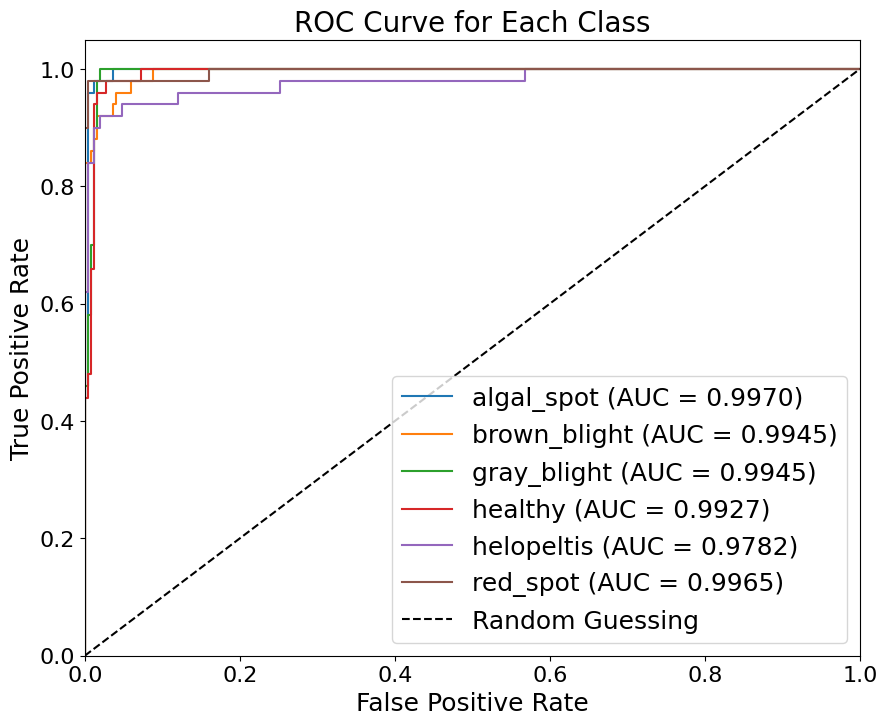

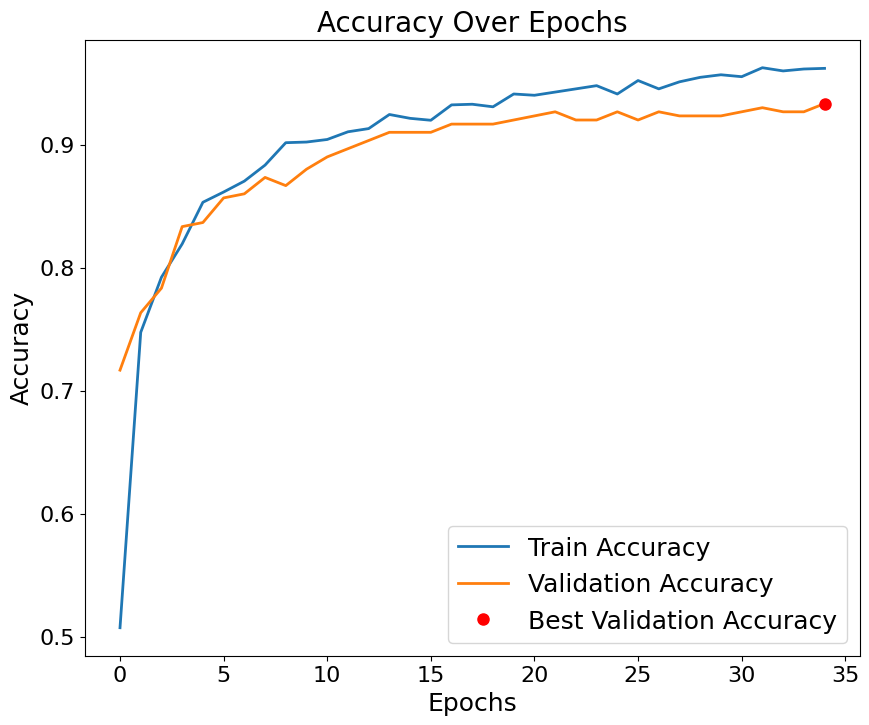

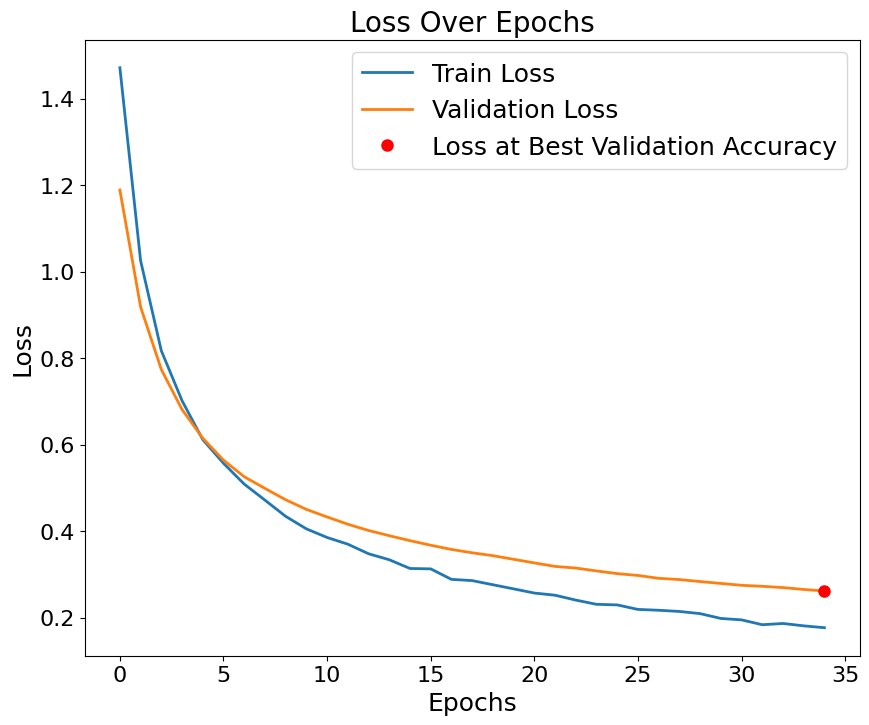

In [20]:
image_size = (480, 480)
model_name = 'EfficientNetV2M'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 8, 8, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 8454      
                                                                 
Total params: 7,777,023
Trainable params: 8,454
Non-trainable params: 7,768,569
_________________________________________________________________
Epoch 1/35
     31/Unknown - 12s 251ms/step - loss: 1.3703 - accuracy: 0.5182
Epoch 1: val_accuracy improved from -inf to 0.72333, saving model to best_model_EfficientNetB2.keras
31/31 [=============

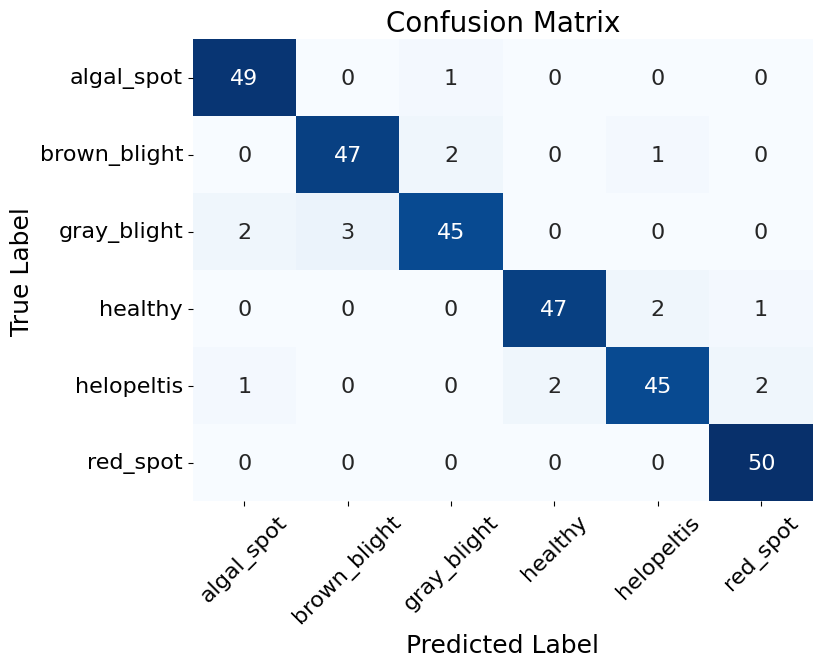

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9423    0.9800    0.9608        50
brown_blight     0.9400    0.9400    0.9400        50
 gray_blight     0.9375    0.9000    0.9184        50
     healthy     0.9592    0.9400    0.9495        50
  helopeltis     0.9375    0.9000    0.9184        50
    red_spot     0.9434    1.0000    0.9709        50

    accuracy                         0.9433       300
   macro avg     0.9433    0.9433    0.9430       300
weighted avg     0.9433    0.9433    0.9430       300

Accuracy: 0.9433
ROC AUC Score: 0.9961


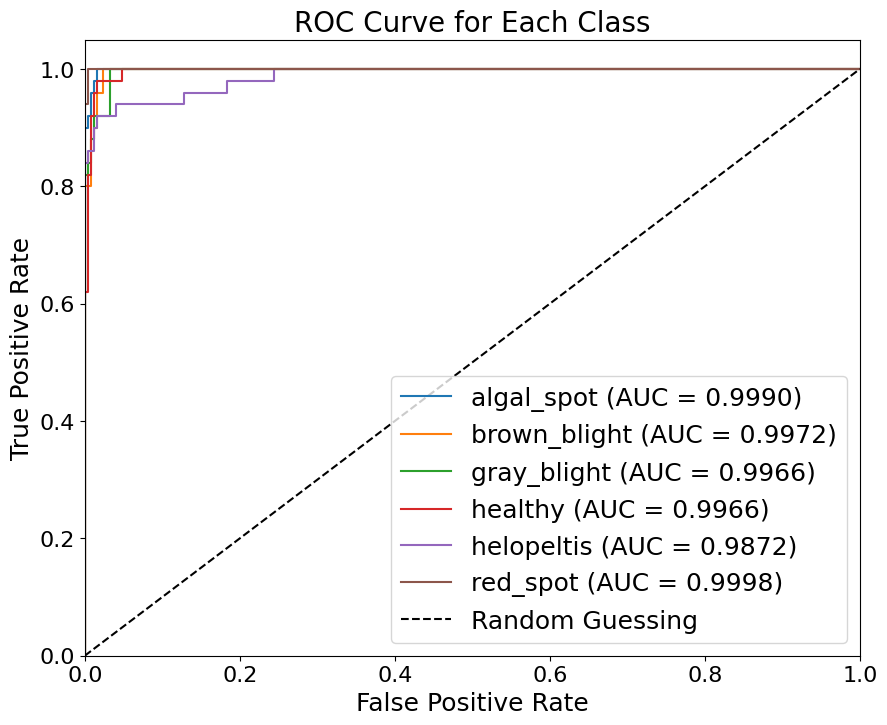

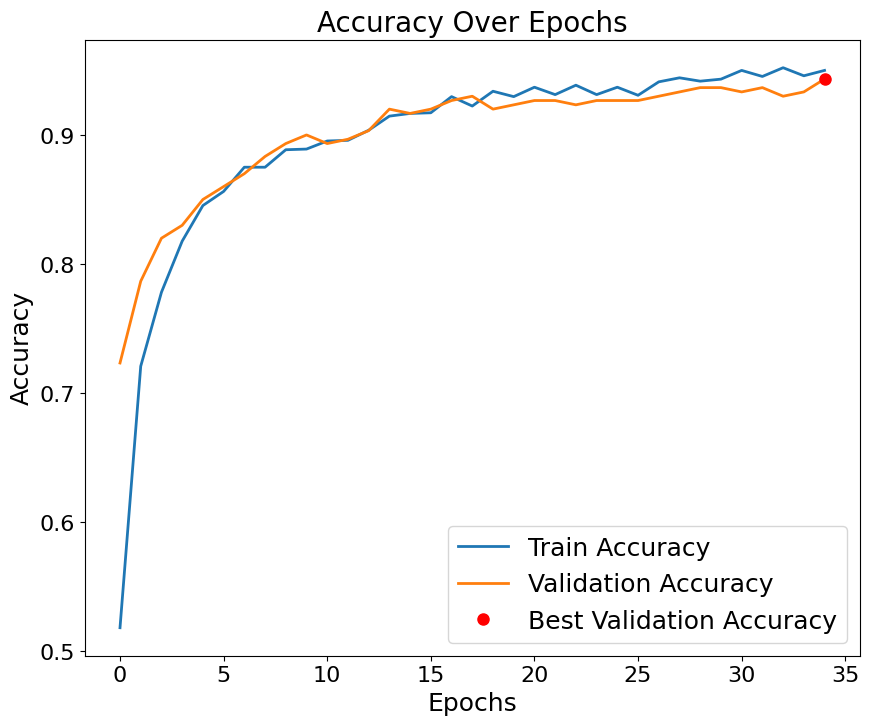

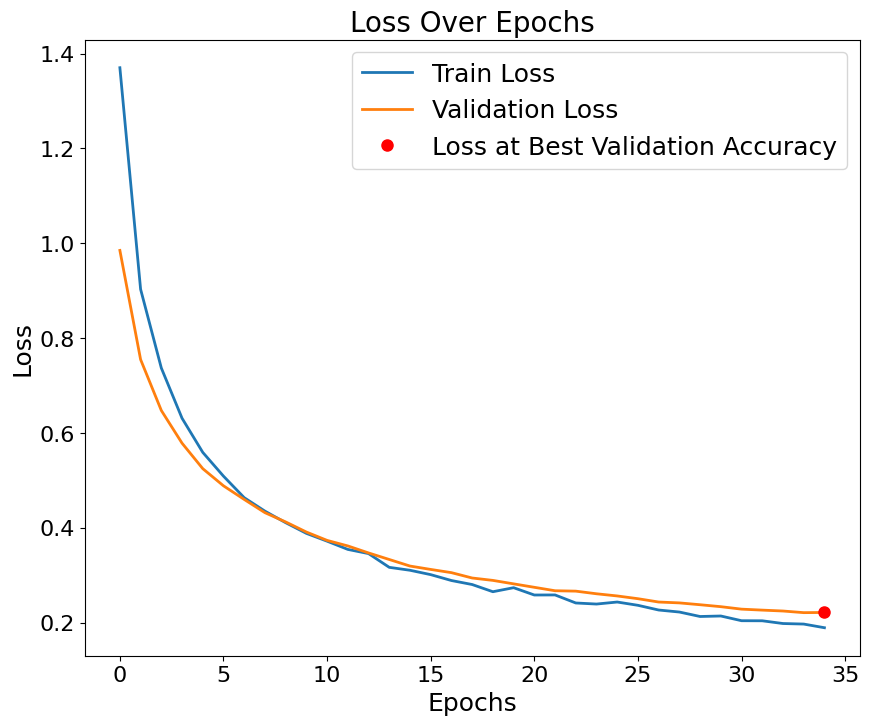

In [13]:
image_size = (240, 240)
model_name = 'EfficientNetB2'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 global_average_pooling2d_1   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 6)                 10758     
                                                                 
Total params: 17,684,581
Trainable params: 10,758
Non-trainable params: 17,673,823
_________________________________________________________________
Epoch 1/35
     31/Unknown - 21s 435ms/step - loss: 1.2044 - accuracy: 0.6292
Epoch 1: val_accuracy improved from -inf to 0.72667, saving model to best_model_EfficientNetB4.keras
31/31 [========

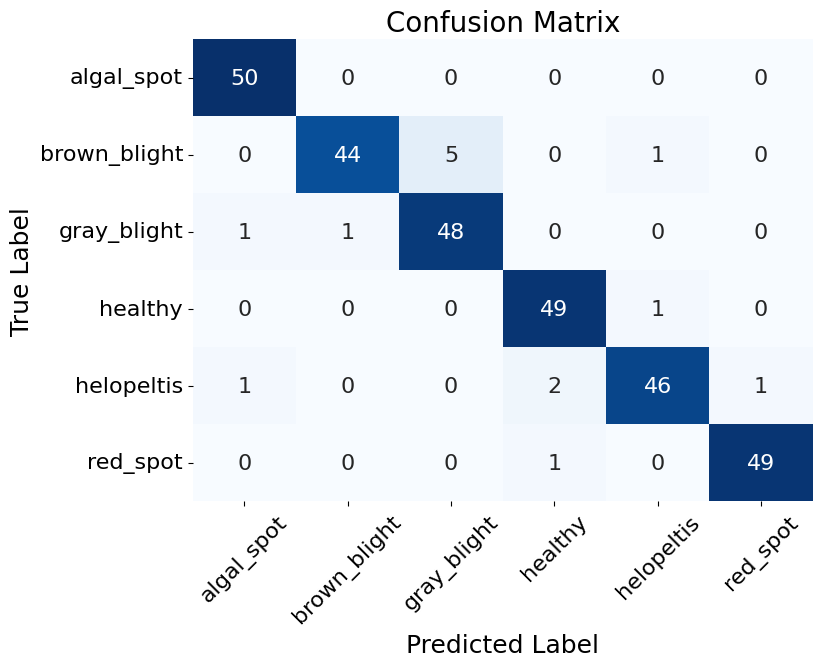

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9615    1.0000    0.9804        50
brown_blight     0.9778    0.8800    0.9263        50
 gray_blight     0.9057    0.9600    0.9320        50
     healthy     0.9423    0.9800    0.9608        50
  helopeltis     0.9583    0.9200    0.9388        50
    red_spot     0.9800    0.9800    0.9800        50

    accuracy                         0.9533       300
   macro avg     0.9543    0.9533    0.9531       300
weighted avg     0.9543    0.9533    0.9531       300

Accuracy: 0.9533
ROC AUC Score: 0.9970


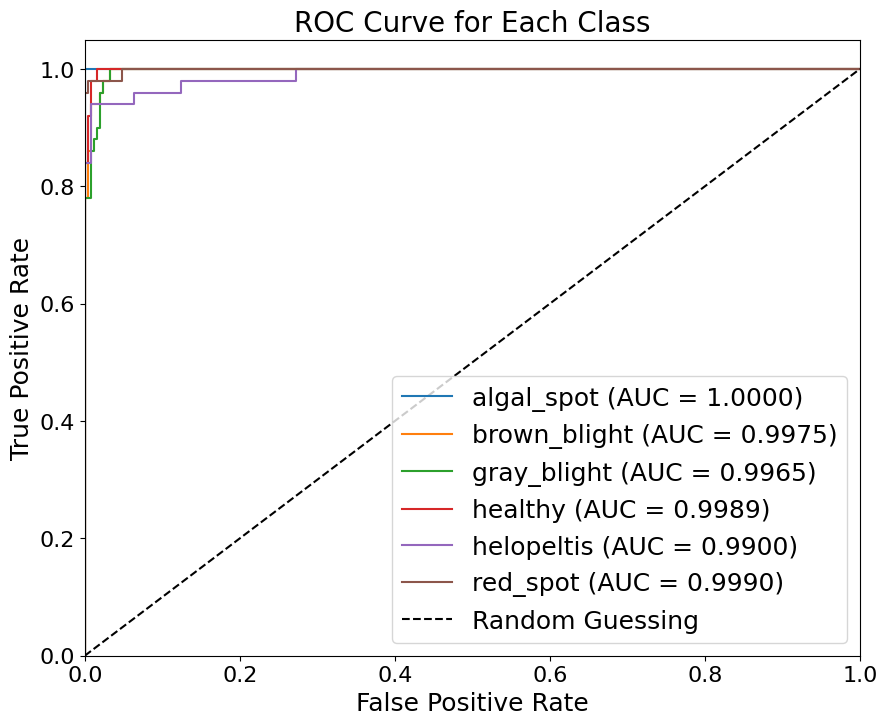

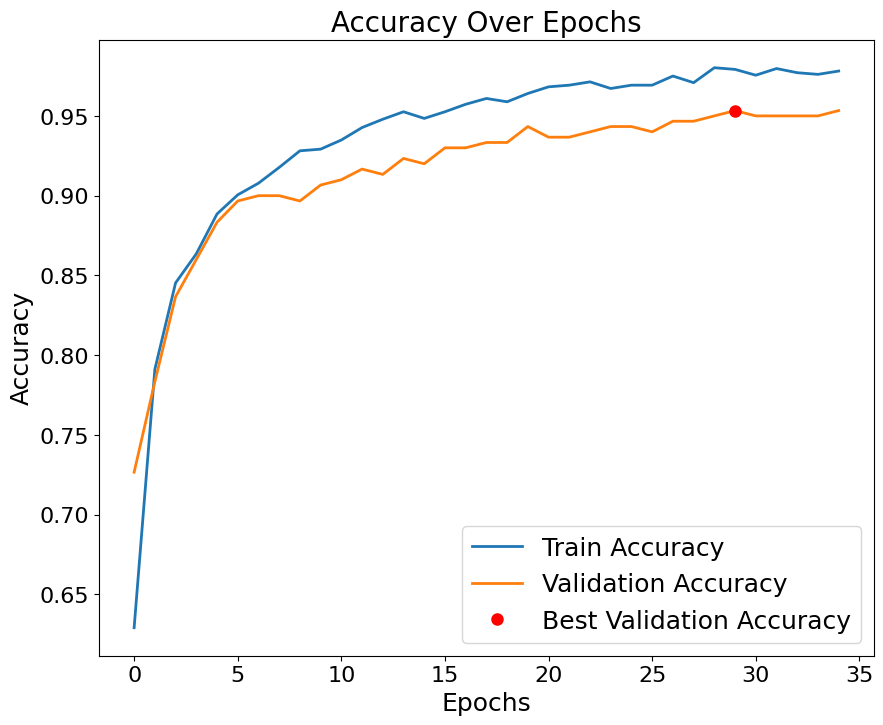

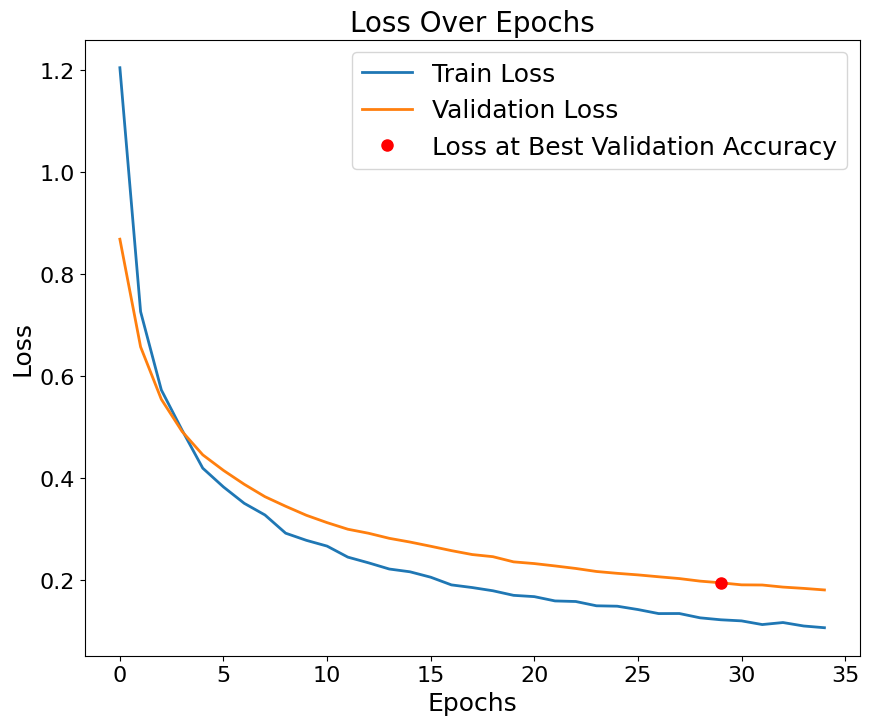

In [13]:
image_size = (380, 380)
model_name = 'EfficientNetB4'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

Found 5867 files belonging to 6 classes.
115263384/115263384 [==============================] - 6s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional)  (None, 15, 15, 2048)     28513527  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 28,525,821
Trainable params: 12,294
Non-trainable params: 28,513,527
_________________________________________________________________
Epoch 1/35
     31/Unknown - 34s 821ms/step - loss: 1.3469 - accuracy: 0.5323
Epoch 1: val_accuracy improved from -inf to 0.713

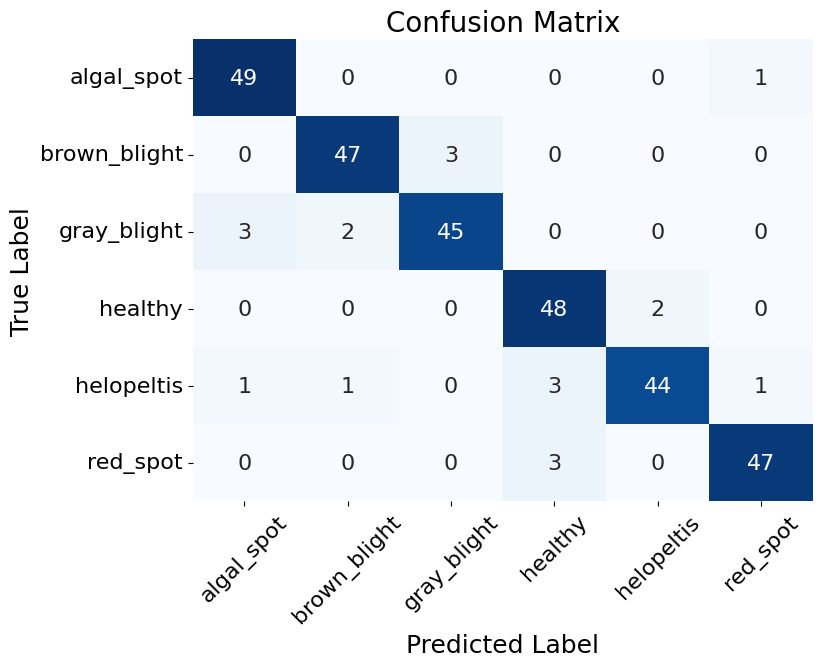

Classification Report:
              precision    recall  f1-score   support

  algal_spot     0.9245    0.9800    0.9515        50
brown_blight     0.9400    0.9400    0.9400        50
 gray_blight     0.9375    0.9000    0.9184        50
     healthy     0.8889    0.9600    0.9231        50
  helopeltis     0.9565    0.8800    0.9167        50
    red_spot     0.9592    0.9400    0.9495        50

    accuracy                         0.9333       300
   macro avg     0.9344    0.9333    0.9332       300
weighted avg     0.9344    0.9333    0.9332       300

Accuracy: 0.9333
ROC AUC Score: 0.9960


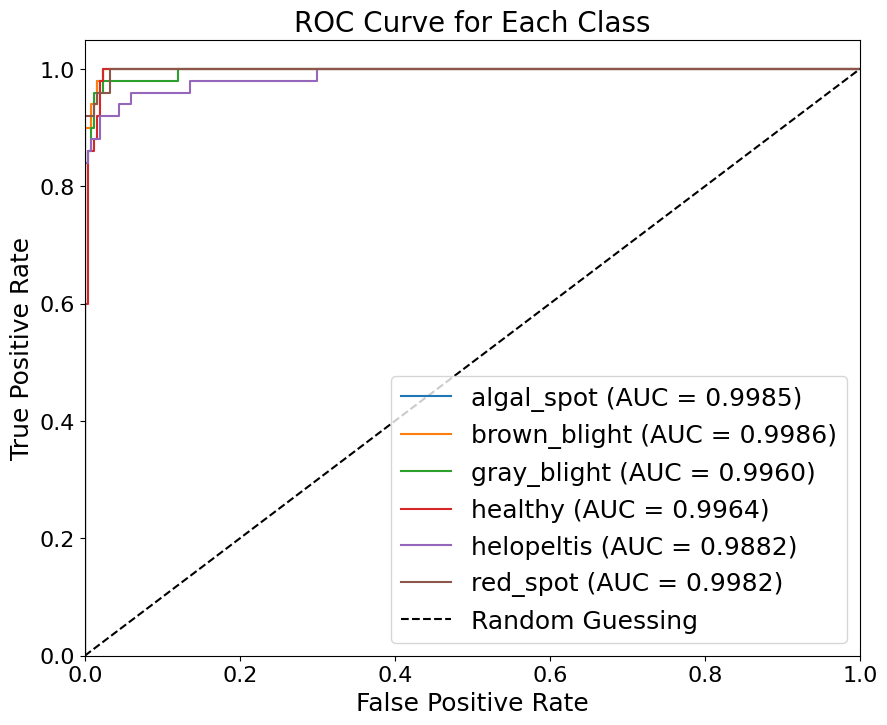

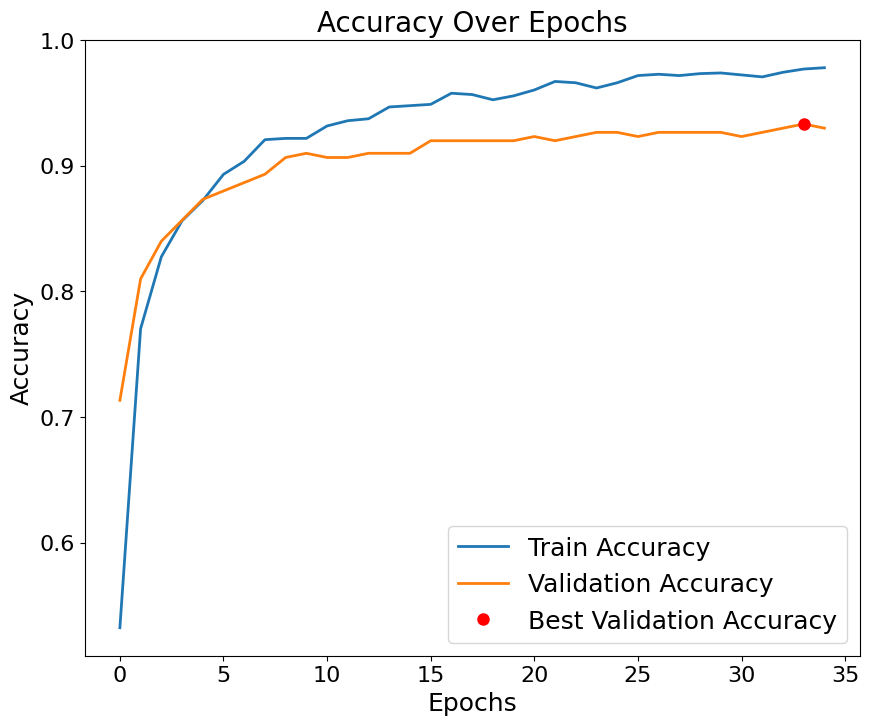

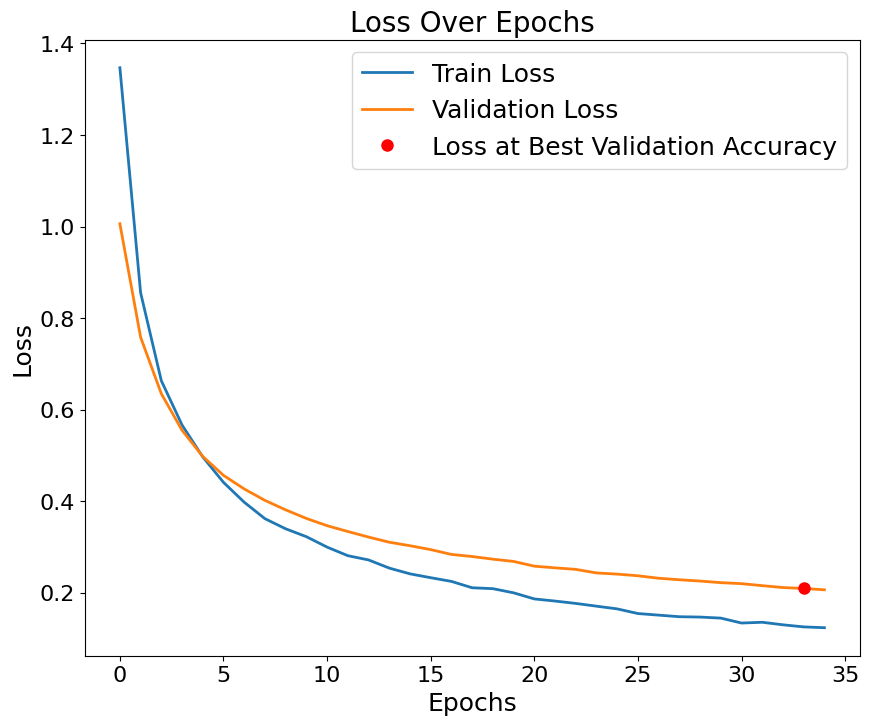

In [19]:
image_size = (456, 456)
model_name = 'EfficientNetB5'
name = model_name

dataset = load_dataset(data_dir, image_size, batch_size, seed)
train_ds, val_ds = stratified_sampling(dataset, sample_size, image_size, batch_size, split_ratio, seed)
train_ds_aug = data_augmentation(train_ds, augmentation_factor, batch_size)

model = build_model(model_name, image_size, num_classes=6)
train_and_evaluate(dataset, name, model, train_ds_aug, val_ds, epochs, num_classes=6)

In [ ]:
# deafult batch_size v1
# b0 224
# b1 240
# b2 260
# b3 300
# b4 380
# b5 456
# b7 528
# b8 600

In [ ]:
# deafult batch_size v2
# b0 224
# b1 240
# b2 260
# b3 300
# s 384
# m 480
# l 480